# Mr.HelpMate AI
## Problem statement
The goal of the project will be to build a robust generative search system capable of effectively and accurately answering questions from a policy document. 

[Group Member Life Insurance Policy](Principal-Sample-Life-Insurance-Policy.pdf)

The project should implement all the three layers effectively. It will be key to try out various strategies and experiments in various layers in order to build an effective search system. Let's explore what you need to do in each of the layers, and the possible experimentations that you can perform based on various choices.

- **The Embedding Layer:** The PDF document needs to be effectively processed, cleaned, and chunked for the embeddings. Here, the choice of the chunking strategy will have a large impact on the final quality of the retrieved results. So, make sure that you try out various stratgies and compare their performances.
Another important aspect in the embedding layer is the choice of the embedding model. You can choose to embed your chunks using the OpenAI embedding model or any model from the SentenceTransformers library on HuggingFace.
- **The Search Layer:** Here, you first need to design at least 3 queries against which you will test your system. You need to understand and skim through the document, and accordingly come up with some queries, the answers to which can be found in the policy document.
Next, you need to embed the queries and search your ChromaDB vector database against each of these queries. Implementing a cache mechanism is also mandatory.
Finally, you need to implement the re-ranking block, and for this you can choose from a range of cross-encoding models on HuggingFace. 
- **The Generation Layer:** In the generation layer, the final prompt that you design is the major component. Make sure that the prompt is exhaustive in its instructions, and the relevant information is correctly passed to the prompt. You may also choose to provide some few-shot examples in an attempt to improve the LLM output.
Make sure you try out different strategies and models in each layer, and you might be surprised with the variety of top answers retrieved and generated by your system. 

**Note:** You need to test your system with at least 3 self-designed queries that can help you gauge the quality of outputs delivered by your system. Also, as a check, you need to submit the screenshots of the outputs along with the code and documentation. The details of the screenshots that you need to share are provided below.

- **Top 3 Results from the Search Layer:** You need to share 3 screenshots against 3 self-designed queries that clearly showcase the top 3 results/chunks retrieved from the search layer. Please share 1 screenshot for each query and its output.
- **Final Generated Answer from the Generation Layer:** Here, you are required to share 3 screenshots of the same 3 queries with the final output generated by the LLM in the generation layer. Please share one screenshot for each query and its output.

So, overall, you will need to share 6 screenshots.

### Importing libraries

In [1]:
import pdfplumber
from operator import itemgetter
import json
from pathlib import Path
import pandas as pd

In [2]:
from IPython.display import Markdown, display
import time

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Rag Components
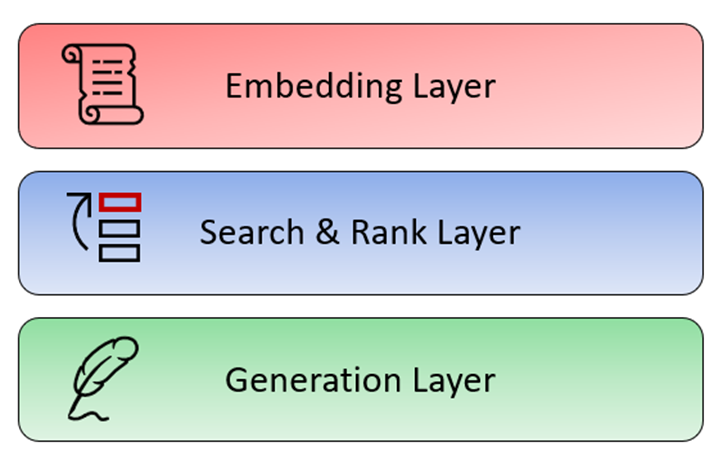

<br/>
<br/>
<br/>

# RAG architecture
This will be a three step process.
#### Step 1: **Text Processing with Embedding model and storing to Vector store**
<img src="Step1.png"/>

<br/>
<br/>
<br/>

#### Step 2: **Query Embedding and searching in Vector cache and Vector store**
<img src="Step2.png"/>

### The Results are selected after reranking using the **cross encoder ranking**

<img src="cross_encoder.png"/>

<br/>
<br/>
<br/>

#### Step 3: **Generate Search layer - Generate response from LLM based on query prompt and search results**
<img src="Step3.png"/>

# Step 1: **Text Processing with Embedding model and storing to Vector store**
<img src="Step1.png"/>

## **Embedding Layer**
- Processing the Text

In [4]:
pdf_path = "dataset"
sample_pdf = "Principal-Sample-Life-Insurance-Policy.pdf"

In [5]:
def preprocess_pdf(pdf_path):
    pages = 0
    tables = []
    text_length = []
    char_length = []
    with pdfplumber.open(pdf_path) as pdf:
        pages = len(pdf.pages)
        for page in pdf.pages:
            if len(page.extract_tables()) > 0:
                tables.append(page.extract_tables())
            text_length.append(len(page.extract_text().split(" ")))
            char_length.append([len(word) for word in page.extract_text().split(" ")])

        char_length = [sum(char, 0) for char in char_length]
    print(f"""
    Total Pages:                 {pages}
    Total Tables:                {len(tables)}
    Total Words:                 {sum(text_length, 0)}
    Max Words in a Page:         {max(text_length)}
    Total Charachters:           {sum(char_length, 0)}
    Max Charachters in a Page:   {max(char_length)}
    """)

In [6]:
preprocess_pdf(f"{pdf_path}/{sample_pdf}")


    Total Pages:                 64
    Total Tables:                0
    Total Words:                 15311
    Max Words in a Page:         425
    Total Charachters:           84231
    Max Charachters in a Page:   2277
    


#### Observation
- Total number of pages are `64`
- There are no tables found
- Total words in the PDF is `15311`
- Maximum word in a page is `425`
- Total charchters `84231`
- Maximum charachters in a page `2277`
<br/>
<br/>

#### Do we need table processing?
- Table processing is not needed as it does not have any table
- We can use any model that supports tokens within the limit of page level charachters/ words

### PDF processing
- Extract text
- Extract tables (if any)
- Generate a dataframe from the PDF

In [7]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [8]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []

    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

In [9]:
def generate_data_from_pdf(pdf_path):
    # Define the directory containing the PDF files
    pdf_directory = Path(pdf_path)
    
    # Initialize an empty list to store the extracted texts and document names
    data = []

    print(f"{len(list(pdf_directory.glob('*.pdf')))} PDF file(s) to parse")
    # Loop through all files in the directory
    for pdf_path in pdf_directory.glob("*.pdf"):
    
        # Process the PDF file
        print(f"...Processing {pdf_path.name}")
    
        # Call the function to extract the text from the PDF
        extracted_text = extract_text_from_pdf(pdf_path)
    
        # Convert the extracted list to a PDF, and add a column to store document names
        extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
        extracted_text_df['Document Name'] = pdf_path.name
    
        # Append the extracted text and document name to the list
        data.append(extracted_text_df)
    
        # Print a message to indicate progress
        print(f"Finished processing {pdf_path.name}")
    
    # Print a message to indicate all PDFs have been processed
    print("All PDFs have been processed.")

    return data

In [10]:
pdfs_data = generate_data_from_pdf(pdf_path=pdf_path)

1 PDF file(s) to parse
...Processing Principal-Sample-Life-Insurance-Policy.pdf
Finished processing Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [11]:
pdfs_data

[   Page No.  \
 0    Page 1   
 1    Page 2   
 2    Page 3   
 3    Page 4   
 4    Page 5   
 5    Page 6   
 6    Page 7   
 7    Page 8   
 8    Page 9   
 9   Page 10   
 10  Page 11   
 11  Page 12   
 12  Page 13   
 13  Page 14   
 14  Page 15   
 15  Page 16   
 16  Page 17   
 17  Page 18   
 18  Page 19   
 19  Page 20   
 20  Page 21   
 21  Page 22   
 22  Page 23   
 23  Page 24   
 24  Page 25   
 25  Page 26   
 26  Page 27   
 27  Page 28   
 28  Page 29   
 29  Page 30   
 30  Page 31   
 31  Page 32   
 32  Page 33   
 33  Page 34   
 34  Page 35   
 35  Page 36   
 36  Page 37   
 37  Page 38   
 38  Page 39   
 39  Page 40   
 40  Page 41   
 41  Page 42   
 42  Page 43   
 43  Page 44   
 44  Page 45   
 45  Page 46   
 46  Page 47   
 47  Page 48   
 48  Page 49   
 49  Page 50   
 50  Page 51   
 51  Page 52   
 52  Page 53   
 53  Page 54   
 54  Page 55   
 55  Page 56   
 56  Page 57   
 57  Page 58   
 58  Page 59   
 59  Page 60   
 60  Page 61   
 61  Pag

In [12]:
pdf_dataframe = pd.concat(pdfs_data, ignore_index=True)
pdf_dataframe

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,"POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the provision of such goods and/or services nor is it liable for the failure of the provision of the same. Further, The Principal is not liable to the applicants/insureds/enrollees for the negligent provision of such goods and/or services by the third party service providers. EXCEPT AS SPECIFICALLY DESCRIBED IN THIS RIDER, ALL OTHER BENEFITS AND PROVISIONS WILL BE AS DESCRIBED IN THE GROUP POLICY. PRINCIPAL LIFE INSURANCE COMPANY DES MOINES, IOWA 50392-0001 GC 806 VAL",Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,"PRINCIPAL LIFE INSURANCE COMPANY (called The Principal in this Group Policy) Des Moines, Iowa 50392-0002 This group insurance policy is issued to: RHODE ISLAND JOHN DOE (called the Policyholder in this Group Policy) The Date of Issue is November 1, 2007. In return for the Policyholder's application and payment of all premiums when due, The Principal agrees to provide: MEMBER LIFE INSURANCE MEMBER ACCIDENTAL DEATH AND DISMEMBERMENT INSURANCE DEPENDENT LIFE INSURANCE subject to the terms and conditions described in this Group Policy. GROUP POLICY NO. GL S655 RENEWABLE TERM - NON-PARTICIPATING CONTRACT STATE OF ISSUE: RHODE ISLAND This policy has been updated effective January 1, 2014 GC 6000 TITLE PAGE",Principal-Sample-Life-Insurance-Policy.pdf
5,Page 6,"TABLE OF CONTENTS PART I - DEFINITIONS PART II - POLICY ADMINISTRATION Section A – Contract Entire Contract Article 1 Policy Changes Article 2 Policyholder Eligibility Requirements Article 3 Policy Incontestability Article 4 Individual Incontestability Article 5 Information to be Furnished Article 6 Certificates Article 7 Assignments Article 8 Dependent Rights Article 9 Policy Interpretation Article 10 Electronic Transactions Article 11 Section B – Premium Payment Responsibility; Due Dates; Grace Period Article 1 Premium Rates Article 2 Premium Rate Changes Article 3 Premium Amount Article 4 Contributions from Members Article 5 Section C - Policy Termination Failure to Pay Premium Article 1 Termination Rights of the Policyholder Article 2 Termination Rights of The Principal Article 3 Policyholder Responsibility to Members Article 4 Section D - Policy Renewal Renewal Article 1 PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS This policy has been updated effective January 1, 2014 GC 6001 TABLE OF CONTENTS, PAGE 1",Principal-Sample-Life-Insurance-Policy.pdf
6,Page 7,"Section A – Eligibility Member Life Insurance Article 1 Member Accidental Death and Dismemberment Insurance Article 2 Dependent Life Insurance Article 3 Section B - Effective D

### Add Text Length field in the dataframe
- Add a new field `Text Length`
- Remove the rows with word count <= 10
- Create the dataframe

In [13]:
pdf_dataframe["Text Length"] = pdf_dataframe.Page_Text.apply(lambda x: len(x.split(" ")))
pdf_dataframe = pdf_dataframe[pdf_dataframe["Text Length"] > 10]
print(pdf_dataframe.shape)
pdf_dataframe = pdf_dataframe.reset_index(drop=True)
pdf_dataframe

(60, 4)


,Page No.,Page_Text,Document Name,Text Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014,Principal-Sample-Life-Insurance-Policy.pdf,30
1,Page 3,"POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the provision of such goods and/or services nor is it liable for the failure of the provision of the same. Further, The Principal is not liable to the applicants/insureds/enrollees for the negligent provision of such goods and/or services by the third party service providers. EXCEPT AS SPECIFICALLY DESCRIBED IN THIS RIDER, ALL OTHER BENEFITS AND PROVISIONS WILL BE AS DESCRIBED IN THE GROUP POLICY. PRINCIPAL LIFE INSURANCE COMPANY DES MOINES, IOWA 50392-0001 GC 806 VAL",Principal-Sample-Life-Insurance-Policy.pdf,230
2,Page 5,"PRINCIPAL LIFE INSURANCE COMPANY (called The Principal in this Group Policy) Des Moines, Iowa 50392-0002 This group insurance policy is issued to: RHODE ISLAND JOHN DOE (called the Policyholder in this Group Policy) The Date of Issue is November 1, 2007. In return for the Policyholder's application and payment of all premiums when due, The Principal agrees to provide: MEMBER LIFE INSURANCE MEMBER ACCIDENTAL DEATH AND DISMEMBERMENT INSURANCE DEPENDENT LIFE INSURANCE subject to the terms and conditions described in this Group Policy. GROUP POLICY NO. GL S655 RENEWABLE TERM - NON-PARTICIPATING CONTRACT STATE OF ISSUE: RHODE ISLAND This policy has been updated effective January 1, 2014 GC 6000 TITLE PAGE",Principal-Sample-Life-Insurance-Policy.pdf,110
3,Page 6,"TABLE OF CONTENTS PART I - DEFINITIONS PART II - POLICY ADMINISTRATION Section A – Contract Entire Contract Article 1 Policy Changes Article 2 Policyholder Eligibility Requirements Article 3 Policy Incontestability Article 4 Individual Incontestability Article 5 Information to be Furnished Article 6 Certificates Article 7 Assignments Article 8 Dependent Rights Article 9 Policy Interpretation Article 10 Electronic Transactions Article 11 Section B – Premium Payment Responsibility; Due Dates; Grace Period Article 1 Premium Rates Article 2 Premium Rate Changes Article 3 Premium Amount Article 4 Contributions from Members Article 5 Section C - Policy Termination Failure to Pay Premium Article 1 Termination Rights of the Policyholder Article 2 Termination Rights of The Principal Article 3 Policyholder Responsibility to Members Article 4 Section D - Policy Renewal Renewal Article 1 PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS This policy has been updated effective January 1, 2014 GC 6001 TABLE OF CONTENTS, PAGE 1",Principal-Sample-Life-Insurance-Policy.pdf,153
4,Page 7,"Section A – Eligibility Member Life Insurance Article 1 Member Accidental Death and Dismemberment Insurance Article 2 Dependent Life Insurance Article 3 Section B - Effective Dates Member Life Insurance Article 1 Member Accidental Death and Dismemberment Insurance Article 2 Dependent Life Insurance Article 3 Section C - I

## Chunking
- Single page chunking with fixed length and overlap in the same page
- Generally Insurance PDFs does not spill context over pages so we are not overlapping the chunking across pages
- Return the dataframe with `DocumentName`, `Page_Text`, and `PageNo.`


In [14]:
def chunk_text(row):
    word_limit = 250
    sample_text = row["Page_Text"].split(".")
    
    new_sample_text = []
    previous_text = ""

    pages = []
    
    for text in sample_text:
        if len(text) < 3:
            if previous_text == "":
                previous_text = text
            else:
                previous_text = previous_text + " " + text
            continue
        else:
            new_sample_text.append(previous_text + " " + text)
            previous_text = ""
    
    sentence_list = []
    new_sentence = ""
    current_count = 0
    for index, text in enumerate(new_sample_text):
        if current_count + len(text.split(" ")) < word_limit:
            if new_sentence == "":
                new_sentence = text
            else:
                new_sentence += ". " + text
        else:
            sentence_list.append(new_sentence.strip())
            new_sentence = (".".join(new_sentence.split(".")[-2:]) + ". " + text).strip()
            current_count = len(new_sentence.split(' '))
            continue
                                
        current_count += len(text.split(" "))
    
    
    sentence_list.append(new_sentence.strip())

    page_data = [{"Page No." : row["Page No."], "Page_Text" : sentence, "Document Name": row["Document Name"]} for sentence in sentence_list]
    
    return page_data

In [15]:
def generate_document():
    data = []
    for index in range(0, pdf_dataframe.shape[0]):
        result = chunk_text((pdf_dataframe.iloc[index])[["Page No.", "Page_Text", "Document Name"]])
        data.append(result)

    return data

In [16]:
pdf_dataframe = pd.DataFrame([element for innerList in generate_document() for element in innerList])

### Add `text length` field in the dataframe

In [17]:
pdf_dataframe["Text Length"] = pdf_dataframe.Page_Text.apply(lambda x: len(x.split(" ")))
display(pdf_dataframe)

,Page No.,Page_Text,Document Name,Text Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014,Principal-Sample-Life-Insurance-Policy.pdf,30
1,Page 3,"POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i. e , optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the provision of such goods and/or services nor is it liable for the failure of the provision of the same. Further, The Principal is not liable to the applicants/insureds/enrollees for the negligent provision of such goods and/or services by the third party service providers. EXCEPT AS SPECIFICALLY DESCRIBED IN THIS RIDER, ALL OTHER BENEFITS AND PROVISIONS WILL BE AS DESCRIBED IN THE GROUP POLICY. PRINCIPAL LIFE INSURANCE COMPANY DES MOINES, IOWA 50392-0001 GC 806 VAL",Principal-Sample-Life-Insurance-Policy.pdf,244
2,Page 5,"PRINCIPAL LIFE INSURANCE COMPANY (called The Principal in this Group Policy) Des Moines, Iowa 50392-0002 This group insurance policy is issued to: RHODE ISLAND JOHN DOE (called the Policyholder in this Group Policy) The Date of Issue is November 1, 2007. In return for the Policyholder's application and payment of all premiums when due, The Principal agrees to provide: MEMBER LIFE INSURANCE MEMBER ACCIDENTAL DEATH AND DISMEMBERMENT INSURANCE DEPENDENT LIFE INSURANCE subject to the terms and conditions described in this Group Policy. GROUP POLICY NO. GL S655 RENEWABLE TERM - NON-PARTICIPATING CONTRACT STATE OF ISSUE: RHODE ISLAND This policy has been updated effective January 1, 2014 GC 6000 TITLE PAGE",Principal-Sample-Life-Insurance-Policy.pdf,116
3,Page 6,"TABLE OF CONTENTS PART I - DEFINITIONS PART II - POLICY ADMINISTRATION Section A – Contract Entire Contract Article 1 Policy Changes Article 2 Policyholder Eligibility Requirements Article 3 Policy Incontestability Article 4 Individual Incontestability Article 5 Information to be Furnished Article 6 Certificates Article 7 Assignments Article 8 Dependent Rights Article 9 Policy Interpretation Article 10 Electronic Transactions Article 11 Section B – Premium Payment Responsibility; Due Dates; Grace Period Article 1 Premium Rates Article 2 Premium Rate Changes Article 3 Premium Amount Article 4 Contributions from Members Article 5 Section C - Policy Termination Failure to Pay Premium Article 1 Termination Rights of the Policyholder Article 2 Termination Rights of The Principal Article 3 Policyholder Responsibility to Members Article 4 Section D - Policy Renewal Renewal Article 1 PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS This policy has been updated effective January 1, 2014 GC 6001 TABLE OF CONTENTS, PAGE 1",Principal-Sample-Life-Insurance-Policy.pdf,153
4,Page 7,"Section A – Eligibility Member Life Insurance Article 1 Member Accidental Death and Dismemberment Insurance Article 2 Dependent Life Insurance Article 3 Section B - Effective Dates Member Life Insurance Article 1 Member Accidental Death and Dismemberment Insurance Article 2 Dependent Life Insurance Article 3 Section C - 

In [18]:
max(pdf_dataframe["Text Length"])

283

In [19]:
pdf_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Page No.       113 non-null    object
 1   Page_Text      113 non-null    object
 2   Document Name  113 non-null    object
 3   Text Length    113 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 3.7+ KB


### Adding Metadata to the PDF 
- Metadata is the combnation of `PageNo` and `DocumentName`

In [20]:
pdf_dataframe["Metadata"] = pdf_dataframe.apply(lambda x: {"Page No.": x["Page No."], "Document Name" : x["Document Name"][:-4]}, axis=1)
pdf_dataframe

,Page No.,Page_Text,Document Name,Text Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014,Principal-Sample-Life-Insurance-Policy.pdf,30,"{'Page No.': 'Page 1', 'Document Name': 'Principal-Sample-Life-Insurance-Policy'}"
1,Page 3,"POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i. e , optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the provision of such goods and/or services nor is it liable for the failure of the provision of the same. Further, The Principal is not liable to the applicants/insureds/enrollees for the negligent provision of such goods and/or services by the third party service providers. EXCEPT AS SPECIFICALLY DESCRIBED IN THIS RIDER, ALL OTHER BENEFITS AND PROVISIONS WILL BE AS DESCRIBED IN THE GROUP POLICY. PRINCIPAL LIFE INSURANCE COMPANY DES MOINES, IOWA 50392-0001 GC 806 VAL",Principal-Sample-Life-Insurance-Policy.pdf,244,"{'Page No.': 'Page 3', 'Document Name': 'Principal-Sample-Life-Insurance-Policy'}"
2,Page 5,"PRINCIPAL LIFE INSURANCE COMPANY (called The Principal in this Group Policy) Des Moines, Iowa 50392-0002 This group insurance policy is issued to: RHODE ISLAND JOHN DOE (called the Policyholder in this Group Policy) The Date of Issue is November 1, 2007. In return for the Policyholder's application and payment of all premiums when due, The Principal agrees to provide: MEMBER LIFE INSURANCE MEMBER ACCIDENTAL DEATH AND DISMEMBERMENT INSURANCE DEPENDENT LIFE INSURANCE subject to the terms and conditions described in this Group Policy. GROUP POLICY NO. GL S655 RENEWABLE TERM - NON-PARTICIPATING CONTRACT STATE OF ISSUE: RHODE ISLAND This policy has been updated effective January 1, 2014 GC 6000 TITLE PAGE",Principal-Sample-Life-Insurance-Policy.pdf,116,"{'Page No.': 'Page 5', 'Document Name': 'Principal-Sample-Life-Insurance-Policy'}"
3,Page 6,"TABLE OF CONTENTS PART I - DEFINITIONS PART II - POLICY ADMINISTRATION Section A – Contract Entire Contract Article 1 Policy Changes Article 2 Policyholder Eligibility Requirements Article 3 Policy Incontestability Article 4 Individual Incontestability Article 5 Information to be Furnished Article 6 Certificates Article 7 Assignments Article 8 Dependent Rights Article 9 Policy Interpretation Article 10 Electronic Transactions Article 11 Section B – Premium Payment Responsibility; Due Dates; Grace Period Article 1 Premium Rates Article 2 Premium Rate Changes Article 3 Premium Amount Article 4 Contributions from Members Article 5 Section C - Policy Termination Failure to Pay Premium Article 1 Termination Rights of the Policyholder Article 2 Termination Rights of The Principal Article 3 Policyholder Responsibility to Members Article 4 Section D - Policy Renewal Renewal Article 1 PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS This policy has been updated effective January 1, 2014 GC 6001 TABLE OF CONTENTS, PAGE 1",Principal-Sample-Life-Insurance-Policy.pdf,153,"{'Page No.': 'Page 6', 'Document Name': 'Principal-Sample-Life-Insuran

## Embedding with Gemini and ChromaDB store

In [21]:
gemini_key = open("API/gemini_key", "r").read()

#### Import the Required Libraries

In [22]:
import google.generativeai as genai
genai.configure(api_key=gemini_key)

import chromadb
from chromadb import Documents, EmbeddingFunction, Embeddings
client_db = chromadb.PersistentClient()

### Gemini Model to return the encoding
- For encoding, using the `models/text-embedding-004`

In [23]:
class GeminiEmbeddingFunction(EmbeddingFunction):
    def __call__(self, input: Documents) -> Embeddings:
        model="models/text-embedding-004"
        title = "Custom query"
        return genai.embed_content(model=model, content=input, task_type="retrieval_document", title=title)["embedding"]

In [24]:
gemini_collection = "Gemini_RAG_on_Insurance"
gemini_collection_cache = "Gemini_RAG_on_Insurance_cache"

### Store the document with Embedding in the Vector Store
- Ids will be the indexing of the chunk in the list
- store will save metadata, id and documents (in encoded format)

In [25]:
def gemini_insertToDBPipeline(insurance_pdfs_data):
    embeddings = []

    documents_list = insurance_pdfs_data['Page_Text'].tolist()
    metadata_list = insurance_pdfs_data['Metadata'].tolist()

    try:
        coll = client_db.get_collection(name=gemini_collection)
        client_db.delete_collection(name=gemini_collection)
        insurance_collection = client_db.get_or_create_collection(name=gemini_collection, embedding_function=GeminiEmbeddingFunction())
    except:
        insurance_collection = client_db.get_or_create_collection(name=gemini_collection, embedding_function=GeminiEmbeddingFunction())
    
    
    insurance_collection.add(
        documents=documents_list,
        ids=[str(i) for i in range(0, len(documents_list))],
        metadatas = metadata_list
    )
    
    return insurance_collection

In [26]:
gemini_insurance_collection = gemini_insertToDBPipeline(insurance_pdfs_data=pdf_dataframe)

In [27]:
gemini_insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': [[0.05808296054601669,
   0.01626746729016304,
   0.017107166349887848,
   -0.011411067098379135,
   -0.019611956551671028,
   0.013185777701437473,
   0.012549198232591152,
   0.04929949715733528,
   0.03484632074832916,
   0.04377219080924988,
   -0.009162954986095428,
   0.027559656649827957,
   0.025312934070825577,
   0.00272087543271482,
   -0.028180420398712158,
   -0.024827292189002037,
   -0.06434060633182526,
   -0.011103021912276745,
   -0.025857390835881233,
   -0.02561776153743267,
   -0.0044266534969210625,
   0.01705886982381344,
   0.02157258242368698,
   -0.02565539814531803,
   0.04824254661798477,
   -0.0323699451982975,
   -0.02484562061727047,
   -0.06569481641054153,
   -0.02160930261015892,
   -0.11299003660678864,
   0.007263218984007835,
   0.02685205638408661,
   -0.020195672288537025,
   -0.010034088045358658,
   0.006010481156408787,
   0.01802326738834381,
   -0.03495195508003235,
   -0.023728132247924805,
   0.024389

# Step 2: **Query Embedding and searching in Vector cache and Vector store**
<img src="Step2.png"/>

### Cache the collection for already queried request response
- Quality of the search results
- Implementation of cache
- Selection and implementation of a re-ranker

In [28]:
def gemini_create_cache_collection():
    try:
        coll = client_db.get_collection(name=gemini_collection_cache)
        client_db.delete_collection(name=gemini_collection_cache)
        insurance_collection_cache = client_db.get_or_create_collection(name=gemini_collection_cache, embedding_function=GeminiEmbeddingFunction())
    except:
        insurance_collection_cache = client_db.get_or_create_collection(name=gemini_collection_cache, embedding_function=GeminiEmbeddingFunction())

    return insurance_collection_cache

In [29]:
gemini_insurance_collection_cache = gemini_create_cache_collection()

### Semantic search in vector Database
- Take the query and check if a similar query is already present in cache
- we are using `distance` threshold 0.2 to maintain accuracy
- If the query is present then extract it from the cache and return the results
- If it is not present in cache then search in the actual database
- Store the results in Cache db along with the query
- Return the results

In [30]:
def get_results_gemini(query):
    threshold = 0.2
    
    cache_result = gemini_insurance_collection_cache.query(
                        query_texts = query,
                        n_results = 1
                    )

    if cache_result["distances"][0] == [] or cache_result["distances"][0][0] > threshold:
        query_result = gemini_insurance_collection.query(
                            query_texts=query,
                            n_results=10
                        )
        Keys = []
        Values = []
        for key, val in query_result.items():
            if val is None:
                continue
            for i in range(10):
                try:
                    Keys.append(str(key) + str(i))
                    Values.append(str(val[0][i]))
                except:
                    continue
    
        gemini_insurance_collection_cache.add(
            documents=[query],
            ids=[query],
            metadatas=dict(zip(Keys, Values))
        )
        # print("Result is not found in cache")
        result_dict = {
            "Metadatas" : query_result["metadatas"][0], 
            "Documents": query_result["documents"][0],
            "Distances": query_result["distances"][0],
            "IDs":query_result["ids"][0]
        }
        result_df = pd.DataFrame.from_dict(result_dict)
        return result_df
    elif cache_result['distances'][0][0] <= threshold:
        cache_result_dict = cache_result['metadatas'][0][0]
        ids = []
        documents = []
        distances = []
        metadatas = []

        for key, value in cache_result_dict.items():
            if "ids" in key:
                ids.append(value)
            elif "documents" in key:
                documents.append(value)
            elif "distances" in key:
                distances.append(value)
            elif "metadatas" in key:
                metadatas.append(value)

        # print("Results found in cache")
        # Create a DataFrame
        result_df = pd.DataFrame({
            'IDs': ids,
            'Documents': documents,
            'Distances': distances,
            'Metadatas': metadatas
        })

        return result_df
    return None

In [31]:
sample_query = "What are the death benefits?"
gemini_results_df = get_results_gemini(query=sample_query)

In [32]:
gemini_results_df

,Metadatas,Documents,Distances,IDs
0,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 48'}","c If a beneficiary dies at the same time or within 15 days after the Member dies, but before The Principal receives Written proof of the Member's death, payment will be made as if the Member survived the beneficiary. d If no beneficiary survives the Member or if the Member has not named a beneficiary, payment will be made in the following order of precedence as numbered: (1) to the Member's spouse; (2) to the Member's children born to or legally adopted by the Member; (3) to the Member's parents; (4) to the Member's brothers and sisters; or (5) if none of the above, to the executor or administrator of the Member's estate. e If The Principal believes a person is not legally able to give a valid receipt, as determined by The Principal, for a payment, and no guardian has been appointed, The Principal may pay whoever has assumed the care and support of the person. Article 5 - Settlement of Proceeds When The Principal receives Written proof of the Member's death, the Scheduled Benefit (or approved amount, if applicable) in force for the Member, less any Accelerated Benefit payment as described in PART IV, Section A, Article 7 will be placed in an interest-bearing draft account at an interest rate determined by The Principal, unless a lump sum or other settlement option has been elected",0.482633,83
1,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 46'}","PART IV - BENEFITS Section A - Member Life Insurance Article 1 - Schedule of Insurance Subject to the Effective Date provisions of PART III, Section B, and the qualifying provisions of this Section A, the Scheduled Benefit for an insured Member will be based on his or her class: Class *Scheduled Benefit ALL MEMBERS $10,000 However, if a Member has received any payments under the Accelerated Benefits provision as described in Section A, Article 7, the Scheduled Benefit will be reduced by the amount of such payment. *The Scheduled Benefit is subject to the Proof of Good Health requirements as shown in PART III, Section B, Article 1. Because of the Proof of Good Health requirements, the amount of insurance approved by The Principal may be different than the Scheduled Benefit. If the approved amount of insurance is different than the Scheduled Benefit, the approved amount will apply. For the age(s) shown below, the amount of a Member's insurance will be the percentage of the Scheduled Benefit (or approved amount, if applicable) as shown below",0.512368,79
2,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 59'}","Section C - Dependent Life Insurance Article 1 - Schedule of Insurance Subject to the Effective Date provisions of PART III, Section B, the Scheduled Benefit for an insured Dependent will be based on the status of the Dependent: Class ALL MEMBERS Dependent *Scheduled Benefit Spouse $5,000 Children (age at death) 0 days old but less than 6 months $1,000 6 months and older $2,000 *The Scheduled Benefit is subject to the Proof of Good Health requirements as shown in PART III, Section B, Article 1. Because of the Proof of Good Health requirements, the amount of insurance approved by The Principal may be different than the Scheduled Benefit. If the approved amount of insurance is different than the Scheduled Benefit, the approved amount will apply. In no event will a Dependent's Scheduled Benefit be more than 50% of the Member's Scheduled Benefit amount. If a Member elects a Dependent Life benefit in excess of 50% of the Member's Scheduled Benefit amount, the Dependent will be given the highest amount available, not to exceed 50%. Article 2 - Death Benefits Payable If a Dependent dies while insured for Dependent Life Insurance under this Group Policy, The Principal will pay the Scheduled Benefit (or approved amount, if applicable) in force for that Dependent on the date of death",0.529088,105
3,"{'Docu

### Reranking the search results using the `CrossEncoder`
- Use the `CrossEncoder` from `sentence_transformers`
- Rank the results based on cross encoder rankings
- High rank is better than the low rank in CrossEncoder
- Cross Encoder takes the array of `Query` and `Response` and then compares the results and rank them as per relation to the query


### The Results are selected after reranking using the **cross encoder ranking**
<img src="cross_encoder.png"/>

In [33]:
from sentence_transformers import CrossEncoder, util

In [34]:
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/Users/mohit.dubey/anaconda3/envs/miniforge/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Use CrossEncoder to rerank the output from semantic search
- Using `cross-encoder/ms-marco-MiniLM-L-6-v2` to rank

In [35]:
def cross_encoding(results_df):
    cross_inputs = [[sample_query, response] for response in results_df['Documents']]
    cross_rerank_scores = cross_encoder.predict(cross_inputs)
    return cross_rerank_scores

In [36]:
gemini_cross_rerank_scores = cross_encoding(gemini_results_df)

In [37]:
gemini_results_df['Reranked_scores'] = gemini_cross_rerank_scores

In [38]:
gemini_results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 48'}","c If a beneficiary dies at the same time or within 15 days after the Member dies, but before The Principal receives Written proof of the Member's death, payment will be made as if the Member survived the beneficiary. d If no beneficiary survives the Member or if the Member has not named a beneficiary, payment will be made in the following order of precedence as numbered: (1) to the Member's spouse; (2) to the Member's children born to or legally adopted by the Member; (3) to the Member's parents; (4) to the Member's brothers and sisters; or (5) if none of the above, to the executor or administrator of the Member's estate. e If The Principal believes a person is not legally able to give a valid receipt, as determined by The Principal, for a payment, and no guardian has been appointed, The Principal may pay whoever has assumed the care and support of the person. Article 5 - Settlement of Proceeds When The Principal receives Written proof of the Member's death, the Scheduled Benefit (or approved amount, if applicable) in force for the Member, less any Accelerated Benefit payment as described in PART IV, Section A, Article 7 will be placed in an interest-bearing draft account at an interest rate determined by The Principal, unless a lump sum or other settlement option has been elected",0.482633,83,-7.065477
1,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 46'}","PART IV - BENEFITS Section A - Member Life Insurance Article 1 - Schedule of Insurance Subject to the Effective Date provisions of PART III, Section B, and the qualifying provisions of this Section A, the Scheduled Benefit for an insured Member will be based on his or her class: Class *Scheduled Benefit ALL MEMBERS $10,000 However, if a Member has received any payments under the Accelerated Benefits provision as described in Section A, Article 7, the Scheduled Benefit will be reduced by the amount of such payment. *The Scheduled Benefit is subject to the Proof of Good Health requirements as shown in PART III, Section B, Article 1. Because of the Proof of Good Health requirements, the amount of insurance approved by The Principal may be different than the Scheduled Benefit. If the approved amount of insurance is different than the Scheduled Benefit, the approved amount will apply. For the age(s) shown below, the amount of a Member's insurance will be the percentage of the Scheduled Benefit (or approved amount, if applicable) as shown below",0.512368,79,-9.682757
2,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 59'}","Section C - Dependent Life Insurance Article 1 - Schedule of Insurance Subject to the Effective Date provisions of PART III, Section B, the Scheduled Benefit for an insured Dependent will be based on the status of the Dependent: Class ALL MEMBERS Dependent *Scheduled Benefit Spouse $5,000 Children (age at death) 0 days old but less than 6 months $1,000 6 months and older $2,000 *The Scheduled Benefit is subject to the Proof of Good Health requirements as shown in PART III, Section B, Article 1. Because of the Proof of Good Health requirements, the amount of insurance approved by The Principal may be different than the Scheduled Benefit. If the approved amount of insurance is different than the Scheduled Benefit, the approved amount will apply. In no event will a Dependent's Scheduled Benefit be more than 50% of the Member's Scheduled Benefit amount. If a Member elects a Dependent Life benefit in excess of 50% of the Member's Scheduled Benefit amount, the Dependent will be given the highest amount available, not to exceed 50%. Article 2 - Death Benefits Payable If a Dependent dies while insured for Dependent Life Insurance under this Group Policy, The Principal will pay the Scheduled Benefit (or approved amount, if applicable) in force for that Dependent on the d

In [39]:
gemini_top_3_semantic = gemini_results_df.sort_values(by='Distances')
gemini_top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 48'}","c If a beneficiary dies at the same time or within 15 days after the Member dies, but before The Principal receives Written proof of the Member's death, payment will be made as if the Member survived the beneficiary. d If no beneficiary survives the Member or if the Member has not named a beneficiary, payment will be made in the following order of precedence as numbered: (1) to the Member's spouse; (2) to the Member's children born to or legally adopted by the Member; (3) to the Member's parents; (4) to the Member's brothers and sisters; or (5) if none of the above, to the executor or administrator of the Member's estate. e If The Principal believes a person is not legally able to give a valid receipt, as determined by The Principal, for a payment, and no guardian has been appointed, The Principal may pay whoever has assumed the care and support of the person. Article 5 - Settlement of Proceeds When The Principal receives Written proof of the Member's death, the Scheduled Benefit (or approved amount, if applicable) in force for the Member, less any Accelerated Benefit payment as described in PART IV, Section A, Article 7 will be placed in an interest-bearing draft account at an interest rate determined by The Principal, unless a lump sum or other settlement option has been elected",0.482633,83,-7.065477
1,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 46'}","PART IV - BENEFITS Section A - Member Life Insurance Article 1 - Schedule of Insurance Subject to the Effective Date provisions of PART III, Section B, and the qualifying provisions of this Section A, the Scheduled Benefit for an insured Member will be based on his or her class: Class *Scheduled Benefit ALL MEMBERS $10,000 However, if a Member has received any payments under the Accelerated Benefits provision as described in Section A, Article 7, the Scheduled Benefit will be reduced by the amount of such payment. *The Scheduled Benefit is subject to the Proof of Good Health requirements as shown in PART III, Section B, Article 1. Because of the Proof of Good Health requirements, the amount of insurance approved by The Principal may be different than the Scheduled Benefit. If the approved amount of insurance is different than the Scheduled Benefit, the approved amount will apply. For the age(s) shown below, the amount of a Member's insurance will be the percentage of the Scheduled Benefit (or approved amount, if applicable) as shown below",0.512368,79,-9.682757
2,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 59'}","Section C - Dependent Life Insurance Article 1 - Schedule of Insurance Subject to the Effective Date provisions of PART III, Section B, the Scheduled Benefit for an insured Dependent will be based on the status of the Dependent: Class ALL MEMBERS Dependent *Scheduled Benefit Spouse $5,000 Children (age at death) 0 days old but less than 6 months $1,000 6 months and older $2,000 *The Scheduled Benefit is subject to the Proof of Good Health requirements as shown in PART III, Section B, Article 1. Because of the Proof of Good Health requirements, the amount of insurance approved by The Principal may be different than the Scheduled Benefit. If the approved amount of insurance is different than the Scheduled Benefit, the approved amount will apply. In no event will a Dependent's Scheduled Benefit be more than 50% of the Member's Scheduled Benefit amount. If a Member elects a Dependent Life benefit in excess of 50% of the Member's Scheduled Benefit amount, the Dependent will be given the highest amount available, not to exceed 50%. Article 2 - Death Benefits Payable If a Dependent dies while insured for Dependent Life Insurance under this Group Policy, The Principal will pay the Scheduled Benefit (or approved amount, if applicable) in force for that Dependent on the d

### Selecting the top three results from Cross-Encoder

In [40]:
gemini_top_3_rerank = gemini_results_df.sort_values(by='Reranked_scores', ascending=False)
gemini_top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
7,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 59'}","If a Member elects a Dependent Life benefit in excess of 50% of the Member's Scheduled Benefit amount, the Dependent will be given the highest amount available, not to exceed 50%. Article 2 - Death Benefits Payable If a Dependent dies while insured for Dependent Life Insurance under this Group Policy, The Principal will pay the Scheduled Benefit (or approved amount, if applicable) in force for that Dependent on the date of death. This policy has been updated effective January 1, 2014 PART IV - BENEFITS GC 6016 Section C - Dependent Life Insurance, Page 1",0.556363,106,2.150768
5,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 60'}","I f a Dependent who was insured dies during the 31-day individual purchase period described in PART III, Section F, Article 2, The Principal will pay the individual policy amount, if any, the Dependent had the right to purchase. Unless a Beneficiary has been designated, payment will be to the Member if he or she survives the Dependent. If the Member does not survive the Dependent and a beneficiary for Dependent Life has not been named, payment will be to the person named as beneficiary for Member Life Insurance. However, if the Member is suspected or charged with the Dependent's death, the Death Benefits Payable may be withheld until additional information has been received or the trial has been held. If the Member is found guilty of the Dependent's death, he or she may be disqualified from receiving any benefit due. Payment may then be made to the executor or administrator of the Dependent's estate. Payment will be subject to the Beneficiary provisions in Article 3 and the Facility of Payment and Settlement of Proceeds provisions of PART IV, Section A. No payment will be made before The Principal receives Written proof of the Dependent's death. Article 3 - Beneficiary A Member may name or later change a named beneficiary by sending a Written request to The Principal. A change will not be effective until recorded by The Principal",0.544227,107,-0.963138
4,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 8'}","Section A - Member Life Insurance Schedule of Insurance Article 1 Death Benefits Payable Article 2 Beneficiary Article 3 Facility of Payment Article 4 Settlement of Proceeds Article 5 Member Life Insurance - Coverage During Disability Article 6 Accelerated Benefits Article 7 Section B - Member Accidental Death and Dismemberment Insurance Schedule of Insurance Article 1 Benefit Qualification Article 2 Benefits Payable Article 3 Seat Belt Benefit Article 4 Loss of Use or Paralysis Benefit Article 5 Loss of Speech and/or Hearing Benefit Article 6 Repatriation Benefit Article 7 Educational Benefit Article 8 Limitations Article 9 Section C - Dependent Life Insurance Schedule of Insurance Article 1 Death Benefits Payable Article 2 Beneficiary Article 3 Section D - Claim Procedures Notice of Claim Article 1 Claim Forms Article 2 Proof of Loss Article 3 Payment, Denial and Review Article 4 Medical Examinations Article 5 Autopsy Article 6 Legal Action Article 7 Time Limits Article 8 This policy has been updated effective January 1, 2014 GC 6001 TABLE OF CONTENTS, PAGE 3",0.532284,5,-1.047806


# Step 3: **Generate Search layer - Generate response from LLM based on query prompt and search results**
<img src="Step3.png"/>

### **RAG: Generative Search using the Gemini model**
#### Working on results from Sementic Search
- Take the input from the Step 2 results
- Use Gemini model `gemini-1.5-flash`
- Write a prompt to generate a human consumable output
- Extract 3 outputs from the LLM and pass it back

#### Working with results generated from LLM
- Take the three output generated from the LLM
- Write another prompt to generate a final output using the previous LLM response
- Show this response to the user

In [41]:
gemini_top_3_RAG = gemini_top_3_rerank[["Documents", "Metadatas"]][:3]
gemini_top_3_RAG

,Documents,Metadatas
7,"If a Member elects a Dependent Life benefit in excess of 50% of the Member's Scheduled Benefit amount, the Dependent will be given the highest amount available, not to exceed 50%. Article 2 - Death Benefits Payable If a Dependent dies while insured for Dependent Life Insurance under this Group Policy, The Principal will pay the Scheduled Benefit (or approved amount, if applicable) in force for that Dependent on the date of death. This policy has been updated effective January 1, 2014 PART IV - BENEFITS GC 6016 Section C - Dependent Life Insurance, Page 1","{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 59'}"
5,"I f a Dependent who was insured dies during the 31-day individual purchase period described in PART III, Section F, Article 2, The Principal will pay the individual policy amount, if any, the Dependent had the right to purchase. Unless a Beneficiary has been designated, payment will be to the Member if he or she survives the Dependent. If the Member does not survive the Dependent and a beneficiary for Dependent Life has not been named, payment will be to the person named as beneficiary for Member Life Insurance. However, if the Member is suspected or charged with the Dependent's death, the Death Benefits Payable may be withheld until additional information has been received or the trial has been held. If the Member is found guilty of the Dependent's death, he or she may be disqualified from receiving any benefit due. Payment may then be made to the executor or administrator of the Dependent's estate. Payment will be subject to the Beneficiary provisions in Article 3 and the Facility of Payment and Settlement of Proceeds provisions of PART IV, Section A. No payment will be made before The Principal receives Written proof of the Dependent's death. Article 3 - Beneficiary A Member may name or later change a named beneficiary by sending a Written request to The Principal. A change will not be effective until recorded by The Principal","{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 60'}"
4,"Section A - Member Life Insurance Schedule of Insurance Article 1 Death Benefits Payable Article 2 Beneficiary Article 3 Facility of Payment Article 4 Settlement of Proceeds Article 5 Member Life Insurance - Coverage During Disability Article 6 Accelerated Benefits Article 7 Section B - Member Accidental Death and Dismemberment Insurance Schedule of Insurance Article 1 Benefit Qualification Article 2 Benefits Payable Article 3 Seat Belt Benefit Article 4 Loss of Use or Paralysis Benefit Article 5 Loss of Speech and/or Hearing Benefit Article 6 Repatriation Benefit Article 7 Educational Benefit Article 8 Limitations Article 9 Section C - Dependent Life Insurance Schedule of Insurance Article 1 Death Benefits Payable Article 2 Beneficiary Article 3 Section D - Claim Procedures Notice of Claim Article 1 Claim Forms Article 2 Proof of Loss Article 3 Payment, Denial and Review Article 4 Medical Examinations Article 5 Autopsy Article 6 Legal Action Article 7 Time Limits Article 8 This policy has been updated effective January 1, 2014 GC 6001 TABLE OF CONTENTS, PAGE 3","{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 8'}"


### Working on results from Sementic Search
- Take the input from the Step 2 results
- Use Gemini model `gemini-1.5-flash`
- Write a prompt to generate a human consumable output
- Extract 3 outputs from the LLM and pass it back

#### Gemini Prompt1

In [42]:
def generate_response_gemini(query, results_df):
    """
    Generate a response using Gemini ChatCompletion based on the user query and retrieved information.
    """
    messages = [
    {"role": "model", "parts": [
        "You are a highly skilled insurance expert tasked with answering user queries using the provided search results. These results are one or more pages from relevant insurance documents that contain the information needed to address the query."
    ]},
    {"role": "model", "parts": [
        f"""You have a user query: '{query}'. The relevant search results are in the DataFrame '{results_df}'. The 'documents' column contains the text from the policy documents, and the 'metadata' column contains the policy name and source page.

        **Your Task:**
        1. **Analyze the Query:** Carefully understand the user's intent and the specific information they are seeking.
        2. **Identify Relevant Documents:** Select the most pertinent documents from the search results based on their content and relevance to the query.
        3. **Extract Key Information:** Carefully extract the required information from the selected documents, ensuring accuracy and completeness.
        4. **Construct a Comprehensive Response:** Craft a clear, concise, and informative response that directly addresses the user's query.
        5. **Provide Citations:** Cite the specific policy names and page numbers where the information was found, using the following format:

            **[Policy Name], [Page Number]**

            **References:**
            * [Policy Name 1], [Page Number 1]
            * [Policy Name 2], [Page Number 2]
            * ...

        **Guidelines:**
        * **Accuracy:** Ensure that your response is factually correct and consistent with the information provided in the documents.
        * **Relevance:** Focus on the most relevant information and avoid providing unnecessary details.
        * **Clarity:** Use plain language and avoid technical jargon.
        * **Completeness:** Provide a comprehensive answer that covers all aspects of the user's query.
        * **Conciseness:** Be brief and to the point, while still providing sufficient detail.

        **Example Response:**
        > The maximum coverage for [policy type] is [amount], as stated in **[Policy Name], [Page Number]**.

            **References:**
            * **[Policy Name 1], [Page Number 1]**
            * **[Policy Name 2], [Page Number 2]**

        Important: Take the policy name and page number from metadata column only
        
        If you cannot find sufficient information to answer the query, indicate that and suggest possible alternative approaches or resources.
        """
    ]},
    {"role": "user", "parts": [query]}
]

    model = genai.GenerativeModel('gemini-1.5-flash')
    gen_config = genai.types.GenerationConfig(candidate_count=1)

    new_responses = [model.generate_content(messages, 
                       generation_config=gen_config) for index in range(3)]

    return [{ "Sr." : index + 1, "Response" :  new_response.candidates[0].content.parts[0].text} for index, new_response in enumerate(new_responses)]



In [43]:
responses = generate_response_gemini(sample_query, gemini_top_3_RAG)

In [44]:
for response in responses:
    print("___"*100)
    print(response["Response"])

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
The death benefit for a Dependent is the Scheduled Benefit (or approved amount, if applicable) in force for that Dependent on the date of death.  

**[Principal-Sample-Life-Insurance-Policy, Page 59]**

If a Dependent who was insured dies during the 31-day individual purchase period described in PART III, Section F, Article 2, The Principal will pay the individual policy amount, if any, the Dependent had the right to purchase. 

**[Principal-Sample-Life-Insurance-Policy, Page 60]**

**References:**
* **Principal-Sample-Life-Insurance-Policy, Page 59**
* **Principal-Sample-Life-Insurance-Policy, Page 60** 

_____________________________________________________________________________________

### Working with results generated from LLM
- Take the three output generated from the LLM
- Write another prompt to generate a final output using the previous LLM response
- Show this response to the user

In [45]:
def generate_final_response_gemini(responses):
    prompt = f"""
            **Task:** Merge the information from the provided responses into a comprehensive summary. Ensure that the summary is clear, concise, and accurately reflects the key points from each response.
            
            **Responses:**
            * **Response 1:** {responses[0]}
            * **Response 2:** {responses[1]}
            * **Response 3:** {responses[2]}
            
            **Output Format:**
            * A concise and informative summary of the key points from the responses.
            * **Citations:** 
            Document Name: [Document Name] 
            Page Numbers: [Page Numbers].
            
            Example Output:
            [Summary of key points]
            **Citations:**
            * Document Name: Principal-Sample-Life-Insurance-Document
            * Page Numbers: 4, 5, 7
            """
    message = [{"role": "model", "parts": [prompt]},
               {"role": "user", "parts": ["generate a response from above instructions"]}]

    model = genai.GenerativeModel('gemini-1.5-flash')
    gen_config = genai.types.GenerationConfig(candidate_count=1)

    new_response = model.generate_content(message, 
                       generation_config=gen_config)
    
    return new_response.candidates[0].content.parts[0].text



#### Gemini Prompt1 Final result

In [46]:
final_response = generate_final_response_gemini(responses)
print(final_response)

This policy provides death benefits for both Members and Dependents. 

**Dependent Death Benefits:**
* The death benefit for a Dependent is the Scheduled Benefit (or approved amount, if applicable) in force for that Dependent on the date of death. [Principal-Sample-Life-Insurance-Policy, Page 59]
* If a Dependent dies during the 31-day individual purchase period, the Principal will pay the individual policy amount, if any, that the Dependent had the right to purchase. [Principal-Sample-Life-Insurance-Policy, Page 60]
* The death benefit is payable to the Member if they survive the Dependent, or to the beneficiary named for Dependent Life Insurance if the Member does not survive the Dependent. [Principal-Sample-Life-Insurance-Policy, Page 59]
* If the Member elects a Dependent Life benefit in excess of 50% of the Member's Scheduled Benefit amount, the Dependent will be given the highest amount available, not to exceed 50%. [Principal-Sample-Life-Insurance-Policy, Page 59]

**Member Deat

In [47]:
display(Markdown(final_response))

This policy provides death benefits for both Members and Dependents. 

**Dependent Death Benefits:**
* The death benefit for a Dependent is the Scheduled Benefit (or approved amount, if applicable) in force for that Dependent on the date of death. [Principal-Sample-Life-Insurance-Policy, Page 59]
* If a Dependent dies during the 31-day individual purchase period, the Principal will pay the individual policy amount, if any, that the Dependent had the right to purchase. [Principal-Sample-Life-Insurance-Policy, Page 60]
* The death benefit is payable to the Member if they survive the Dependent, or to the beneficiary named for Dependent Life Insurance if the Member does not survive the Dependent. [Principal-Sample-Life-Insurance-Policy, Page 59]
* If the Member elects a Dependent Life benefit in excess of 50% of the Member's Scheduled Benefit amount, the Dependent will be given the highest amount available, not to exceed 50%. [Principal-Sample-Life-Insurance-Policy, Page 59]

**Member Death Benefits:**
* The policy provides coverage for the death of a Member. 
* The specific amount of the Member death benefit is not provided in these documents, but you can find the details in the "Member Life Insurance Schedule of Insurance" section of the policy. [Principal-Sample-Life-Insurance-Policy, Page 8]

**Citations:**
* Document Name: Principal-Sample-Life-Insurance-Policy
* Page Numbers: 8, 59, 60 


#### Gemini Prompt2

In [48]:
def generate_response2_gemini(query, results_df):
    """
    Generate a response using Gemini ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "model", "parts":  ["You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."]},
                {"role": "model", "parts": [f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{results_df}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{results_df}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                Important: Take the policy name and page number from metadata column only
                                                
                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """]},
                 {"role": "user", "parts": [query]}
              ]

    model = genai.GenerativeModel('gemini-1.5-flash')
    gen_config = genai.types.GenerationConfig(candidate_count=1)
    
    new_responses = [model.generate_content(messages, 
                       generation_config=gen_config) for index in range(3)]

    return [{ "Sr." : index + 1, "Response" :  new_response.candidates[0].content.parts[0].text} for index, new_response in enumerate(new_responses)]


In [49]:
responses2 = generate_response2_gemini(sample_query, gemini_top_3_RAG)
print(responses2)

[{'Sr.': 1, 'Response': 'If a Dependent dies while insured for Dependent Life Insurance under this Group Policy, The Principal will pay the Scheduled Benefit (or approved amount, if applicable) in force for that Dependent on the date of death. \n\n* **Citation:** Principal-Sample-Life-Insurance-Policy, Page 59\n'}, {'Sr.': 2, 'Response': 'The death benefit is the amount of money paid to the beneficiary of a life insurance policy upon the death of the insured.  The death benefit can be the Scheduled Benefit (or approved amount, if applicable) in force for that Dependent on the date of death. The death benefit can also be the individual policy amount, if any, the Dependent had the right to purchase. \n\n**Citation**\n\n* Principal-Sample-Life-Insurance-Policy, Page 59\n* Principal-Sample-Life-Insurance-Policy, Page 60 \n'}, {'Sr.': 3, 'Response': 'The death benefits are the amount of money that is paid out to the beneficiary when the insured person dies. If a Dependent dies while insured

In [50]:
for response in responses2:
    print("___"*100)
    print(response["Response"])

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
If a Dependent dies while insured for Dependent Life Insurance under this Group Policy, The Principal will pay the Scheduled Benefit (or approved amount, if applicable) in force for that Dependent on the date of death. 

* **Citation:** Principal-Sample-Life-Insurance-Policy, Page 59

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
The death benefit is the amount of money paid to the beneficiary of a life insurance policy upon the death of th

#### Gemini Prompt2 Final

In [51]:
final_response2 = generate_final_response_gemini(responses2)
print(final_response2)

## Summary:

If a dependent dies while insured for Dependent Life Insurance under this Group Policy, the Principal will pay the Scheduled Benefit (or approved amount, if applicable) in force for that Dependent on the date of death. This Scheduled Benefit represents the death benefit payable to the beneficiary. Additionally, the Dependent might have had the right to purchase an individual policy, and the death benefit could be the amount of that individual policy instead.

**Citations:**

* **Document Name:** Principal-Sample-Life-Insurance-Policy
* **Page Numbers:** 59, 60 



In [52]:
display(Markdown(final_response2))

## Summary:

If a dependent dies while insured for Dependent Life Insurance under this Group Policy, the Principal will pay the Scheduled Benefit (or approved amount, if applicable) in force for that Dependent on the date of death. This Scheduled Benefit represents the death benefit payable to the beneficiary. Additionally, the Dependent might have had the right to purchase an individual policy, and the death benefit could be the amount of that individual policy instead.

**Citations:**

* **Document Name:** Principal-Sample-Life-Insurance-Policy
* **Page Numbers:** 59, 60 


### Observation
- Prompt 1 is generating better response so we will move ahead with Prompt 1

# Gemini RAG LLM pipeline
- Get the results of the query from Vector store
- Rerank the result
- Pick top three candidates
- Send these to Gemini LLM to generate 3 responses
- Use these 3 responses to generate the final response

In [53]:
def gemini_pipeline(query):
    results = get_results_gemini(query)
    results['Reranked_scores'] = cross_encoding(results)
    top_3_rerank = results.sort_values(by='Reranked_scores', ascending=False)[["Documents", "Metadatas"]][:3]
    responses = generate_response_gemini(query, top_3_rerank)
    final_response = generate_final_response_gemini(responses)
    result_text = f"#### **Query:** \n{query} \n\n#### **Gemini Response:** \n{final_response}"
    return result_text

In [54]:
def gemini_pipeline_with_original_results(query):
    results = get_results_gemini(query)
    results['Reranked_scores'] = cross_encoding(results)
    top_3_rerank = results.sort_values(by='Reranked_scores', ascending=False)[["Documents", "Metadatas"]][:3]
    responses = generate_response_gemini(query, top_3_rerank)
    final_response = generate_final_response_gemini(responses)
    result_text = f"#### **Query:** \n{query} \n\n#### **Gemini Response:** \n{final_response}"
    return result_text, top_3_rerank

# Test Gemini pipeline results

In [55]:
# Adding delay so that we do not exceed the usage quota
time.sleep(30)
query = "What are the defaulter cases in this policy?"
final_response = gemini_pipeline(query)
display(Markdown(final_response))

#### **Query:** 
What are the defaulter cases in this policy? 

#### **Gemini Response:** 
The provided insurance policy documents do not explicitly define "defaulter cases" or provide a specific definition for policy default.  However, the documents highlight situations where a beneficiary may be disqualified from receiving benefits. 

One such scenario is when a beneficiary is found guilty of causing the insured Member's death. In this case, they may be disqualified from receiving any benefits, and the payment may be directed to a contingent beneficiary, executor, or administrator of the Member's estate. [Principal-Sample-Life-Insurance-Policy, Page 47]  Another scenario involves a beneficiary dying before the insured Member, in which case their share of the benefits will be distributed equally among the Member's surviving beneficiaries. [Principal-Sample-Life-Insurance-Policy, Page 47]

To fully understand what constitutes "defaulter cases" within the context of this policy, it is recommended to consult the full policy document or contact the insurance provider directly.  

**Citations:**
* Document Name: Principal-Sample-Life-Insurance-Policy
* Page Numbers: 47 


In [56]:
# Adding delay so that we do not exceed the usage quota
time.sleep(30)
query = "What are the accidental death in this policy?"
final_response = gemini_pipeline(query)
display(Markdown(final_response))

#### **Query:** 
What are the accidental death in this policy? 

#### **Gemini Response:** 
This policy provides Accidental Death and Dismemberment (AD&D) insurance coverage with a scheduled benefit of $10,000 for all members.  [Principal-Sample-Life-Insurance-Policy, Page 53]  The benefit amount is subject to proof of good health requirements, and may be reduced based on the member's age: 

* Age 70 but less than age 75: 65% of the scheduled benefit
* Age 75 and over: 45% of the scheduled benefit [Principal-Sample-Life-Insurance-Policy, Page 53]

To qualify for the AD&D benefit, the member must: 

* Be insured for AD&D under this policy.
* Suffer an injury caused by external, violent, and accidental means that results in death or dismemberment. [Principal-Sample-Life-Insurance-Policy, Page 53] 

The policy also includes provisions for benefits related to loss of use or paralysis, loss of speech and/or hearing, repatriation, education, and seat belt benefits. [Principal-Sample-Life-Insurance-Policy, Page 8]

**Citations:**
* Document Name: Principal-Sample-Life-Insurance-Policy
* Page Numbers: 8, 53


In [57]:
# Adding delay so that we do not exceed the usage quota
time.sleep(30)
query = "What are the benifits of taking the policy in young age?"
final_response = gemini_pipeline(query)
display(Markdown(final_response))

#### **Query:** 
What are the benifits of taking the policy in young age? 

#### **Gemini Response:** 
Purchasing life insurance at a young age offers several potential advantages, although these benefits are not explicitly stated in the provided documents. 

* **Lower Premiums:** Younger individuals typically pay lower premiums due to their lower risk of death.  [Response 1, Response 2, Response 3]
* **More Coverage Options:** Younger individuals may have access to a wider range of coverage options and potentially secure larger amounts of coverage. [Response 3]
* **Longer Coverage Period:**  Purchasing a policy early allows for a longer period of coverage, providing financial security for beneficiaries over a longer timeframe. [Response 1, Response 2, Response 3]
* **Potential for Growth:** Some policies offer investment components, allowing the policy's value to grow over time, potentially resulting in a larger payout later in life. [Response 1, Response 2]
* **Peace of Mind:**  Having life insurance in place provides financial security for loved ones in case of unexpected death. [Response 2]
* **Builds a Habit:** Early adoption can establish a habit of financial preparedness for future life events. [Response 3]

**Citations:**
* **Document Name:** [Document Name] 
* **Page Numbers:** [Page Numbers] 


In [58]:
# Adding delay so that we do not exceed the usage quota
time.sleep(30)
query = "Are there any tax benefits of this policy?"
final_response = gemini_pipeline(query)
display(Markdown(final_response))

#### **Query:** 
Are there any tax benefits of this policy? 

#### **Gemini Response:** 
The provided documents do not contain information regarding tax benefits associated with the policy. To determine if there are any tax benefits, it is recommended to:

* **Consult with a tax professional:** They can provide guidance based on your specific situation and the policy details.
* **Review the policy documents carefully:** Look for sections on tax implications or refer to the insurer's website for additional information.
* **Contact the insurance company directly:** They can provide details about potential tax benefits and relevant regulations. 
* **Contact your insurance agent:** They may also be able to provide information about tax implications.

**Citations:**
* **Document Name:** Principal-Sample-Life-Insurance-Policy
* **Page Numbers:** 46, 50 


---------------------------
___________________________
---------------------------
___________________________

# Same implementation using the OpenAI

## Step 1: **Text Processing with Embedding model and storing to Vector store**
<img src="Step1.png"/>

- Create the dataframe after parsing the PDF
- Add a new column `Text Length`
- Remove All rows with word count `<= 10`
- Add a new column Metadata with value as combination of `PageNo` and `DocumentName`

In [59]:
pdf_dataframe_openAI = pd.concat(pdfs_data, ignore_index=True)
pdf_dataframe_openAI["Text Length"] = pdf_dataframe_openAI.Page_Text.apply(lambda x: len(x.split(" ")))
pdf_dataframe_openAI = pdf_dataframe_openAI[pdf_dataframe_openAI["Text Length"] > 10]
pdf_dataframe_openAI = pdf_dataframe_openAI.reset_index(drop=True)
pdf_dataframe_openAI["Metadata"] = pdf_dataframe_openAI.apply(lambda x: {"Page No.": x["Page No."], "Document Name" : x["Document Name"][:-4]}, axis=1)
pdf_dataframe_openAI



,Page No.,Page_Text,Document Name,Text Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014,Principal-Sample-Life-Insurance-Policy.pdf,30,"{'Page No.': 'Page 1', 'Document Name': 'Principal-Sample-Life-Insurance-Policy'}"
1,Page 3,"POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the provision of such goods and/or services nor is it liable for the failure of the provision of the same. Further, The Principal is not liable to the applicants/insureds/enrollees for the negligent provision of such goods and/or services by the third party service providers. EXCEPT AS SPECIFICALLY DESCRIBED IN THIS RIDER, ALL OTHER BENEFITS AND PROVISIONS WILL BE AS DESCRIBED IN THE GROUP POLICY. PRINCIPAL LIFE INSURANCE COMPANY DES MOINES, IOWA 50392-0001 GC 806 VAL",Principal-Sample-Life-Insurance-Policy.pdf,230,"{'Page No.': 'Page 3', 'Document Name': 'Principal-Sample-Life-Insurance-Policy'}"
2,Page 5,"PRINCIPAL LIFE INSURANCE COMPANY (called The Principal in this Group Policy) Des Moines, Iowa 50392-0002 This group insurance policy is issued to: RHODE ISLAND JOHN DOE (called the Policyholder in this Group Policy) The Date of Issue is November 1, 2007. In return for the Policyholder's application and payment of all premiums when due, The Principal agrees to provide: MEMBER LIFE INSURANCE MEMBER ACCIDENTAL DEATH AND DISMEMBERMENT INSURANCE DEPENDENT LIFE INSURANCE subject to the terms and conditions described in this Group Policy. GROUP POLICY NO. GL S655 RENEWABLE TERM - NON-PARTICIPATING CONTRACT STATE OF ISSUE: RHODE ISLAND This policy has been updated effective January 1, 2014 GC 6000 TITLE PAGE",Principal-Sample-Life-Insurance-Policy.pdf,110,"{'Page No.': 'Page 5', 'Document Name': 'Principal-Sample-Life-Insurance-Policy'}"
3,Page 6,"TABLE OF CONTENTS PART I - DEFINITIONS PART II - POLICY ADMINISTRATION Section A – Contract Entire Contract Article 1 Policy Changes Article 2 Policyholder Eligibility Requirements Article 3 Policy Incontestability Article 4 Individual Incontestability Article 5 Information to be Furnished Article 6 Certificates Article 7 Assignments Article 8 Dependent Rights Article 9 Policy Interpretation Article 10 Electronic Transactions Article 11 Section B – Premium Payment Responsibility; Due Dates; Grace Period Article 1 Premium Rates Article 2 Premium Rate Changes Article 3 Premium Amount Article 4 Contributions from Members Article 5 Section C - Policy Termination Failure to Pay Premium Article 1 Termination Rights of the Policyholder Article 2 Termination Rights of The Principal Article 3 Policyholder Responsibility to Members Article 4 Section D - Policy Renewal Renewal Article 1 PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS This policy has been updated effective January 1, 2014 GC 6001 TABLE OF CONTENTS, PAGE 1",Principal-Sample-Life-Insurance-Policy.pdf,153,"{'Page No.': 'Page 6', 'Document Name': 'Principal-Sample-Life-Insuranc

In [60]:
import openai
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

## OpenAI Embedding
- Model to be used is `text-embedding-ada-002`

In [61]:
openai_key = open("API/openai_key", "r").read()

In [62]:
model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai_key, model_name=model)

In [63]:
openai_collection = "OpenAI_RAG_on_Insurance"
openai_collection_cache = "OpenAI_RAG_on_Insurance_cache"

## Chunking not needed for OpenAI
- OpenAI can handle more tokens
- The dimension of openAI is also more than Gemini

More can be referenced from here: https://www.pinecone.io/learn/openai-embeddings-v3/

In [64]:
def openai_insertToDBPipeline(insurance_pdfs_data, shouldCreateCollection):
    if shouldCreateCollection:
        embeddings = []
    
        documents_list = pdf_dataframe_openAI['Page_Text'].tolist()
        metadata_list = pdf_dataframe_openAI['Metadata'].tolist()
    
        try:
            coll = client_db.get_collection(name=openai_collection)
            client_db.delete_collection(name=openai_collection)
            insurance_collection = client_db.get_or_create_collection(name=openai_collection, embedding_function=embedding_function)
        except:
            insurance_collection = client_db.get_or_create_collection(name=openai_collection, embedding_function=embedding_function)
        
        
        insurance_collection.add(
            documents=documents_list,
            ids=[str(i) for i in range(0, len(documents_list))],
            metadatas = metadata_list
        )
        
        return insurance_collection
    else:
        insurance_collection = client_db.get_or_create_collection(name=openai_collection, embedding_function=embedding_function)
        return insurance_collection

#### Store the results to colletion

In [65]:
openai_insurance_collection = openai_insertToDBPipeline(insurance_pdfs_data=pdf_dataframe_openAI, shouldCreateCollection=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [66]:
openai_insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': [[-0.022469419986009598,
   0.01871146820485592,
   -0.02729734405875206,
   -0.031290166079998016,
   -0.0036731369327753782,
   0.027923669666051865,
   0.0008538575493730605,
   0.023656828328967094,
   -0.016571523621678352,
   0.004253792576491833,
   -0.005251998547464609,
   0.004058065824210644,
   -0.006273039150983095,
   0.023252326995134354,
   -0.011299951933324337,
   0.030977005138993263,
   0.002877181861549616,
   -0.024726800620555878,
   0.03055945597589016,
   0.007920404896140099,
   0.006413309834897518,
   0.01886804960668087,
   0.00953188817948103,
   0.012689611874520779,
   -0.012356876395642757,
   -0.009440548717975616,
   0.017889415845274925,
   -0.021686512976884842,
   0.023526344448328018,
   0.0030223457142710686,
   0.013283316045999527,
   -0.0145490150898695,
   -0.03361279144883156,
   -0.041180890053510666,
   -0.00845539104193449,
   0.013531235978007317,
   -0.0026716687716543674,
   -0.003868863452225923

# Step 2: **Query Embedding and searching in Vector cache and Vector store**
<img src="Step2.png"/>

## Store the document to ChromaDB
- Create a store
- Create a query cache store
- Search query in cache if result already exist
- If query not present in cache then search in actual store and save the result in cache

In [67]:
def openai_create_cache_collection():
    try:
        coll = client_db.get_collection(name=openai_collection_cache)
        client_db.delete_collection(name=openai_collection_cache)
        insurance_collection_cache = client_db.get_or_create_collection(name=openai_collection_cache, embedding_function=embedding_function)
    except:
        insurance_collection_cache = client_db.get_or_create_collection(name=openai_collection_cache, embedding_function=embedding_function)

    return insurance_collection_cache

In [68]:
openai_insurance_collection_cache = openai_create_cache_collection()

### Semantic search in vector Database
- Take the query and check if a similar query is already present in cache
- we are using `distance` threshold 0.2 to maintain accuracy
- If the query is present then extract it from the cache and return the results
- If it is not present in cache then search in the actual database
- Store the results in Cache db along with the query
- Return the results

In [69]:
def get_results_openai(query):
    threshold = 0.2
    
    cache_result = openai_insurance_collection_cache.query(
                        query_texts = query,
                        n_results = 1
                    )

    if cache_result["distances"][0] == [] or cache_result["distances"][0][0] > threshold:
        query_result = openai_insurance_collection.query(
                            query_texts=query,
                            n_results=10
                        )
        Keys = []
        Values = []
        for key, val in query_result.items():
            if val is None:
                continue
            for i in range(10):
                try:
                    Keys.append(str(key) + str(i))
                    Values.append(str(val[0][i]))
                except:
                    continue
    
        openai_insurance_collection_cache.add(
            documents=[query],
            ids=[query],
            metadatas=dict(zip(Keys, Values))
        )
        # print("Result is not found in cache")
        result_dict = {
            "Metadatas" : query_result["metadatas"][0], 
            "Documents": query_result["documents"][0],
            "Distances": query_result["distances"][0],
            "IDs":query_result["ids"][0]
        }
        result_df = pd.DataFrame.from_dict(result_dict)
        return result_df
    elif cache_result['distances'][0][0] <= threshold:
        cache_result_dict = cache_result['metadatas'][0][0]
        ids = []
        documents = []
        distances = []
        metadatas = []

        for key, value in cache_result_dict.items():
            if "ids" in key:
                ids.append(value)
            elif "documents" in key:
                documents.append(value)
            elif "distances" in key:
                distances.append(value)
            elif "metadatas" in key:
                metadatas.append(value)

        # print("Results found in cache")
        # Create a DataFrame
        result_df = pd.DataFrame({
            'IDs': ids,
            'Documents': documents,
            'Distances': distances,
            'Metadatas': metadatas
        })

        return result_df
    return None

In [70]:
sample_query = "What are the death benefits?"
openai_results_df = get_results_openai(query=sample_query)

In [71]:
openai_results_df

,Metadatas,Documents,Distances,IDs
0,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 47'}","M ember's death, the Death Benefits Payable may be withheld until additional information has been received or the trial has been held. If a Member who was insured dies within the 31-day individual purchase period described in PART III, Section F, The Principal will pay his or her beneficiary the individual policy amount, if any, the Member had the right to purchase. No payment will be made before The Principal receives Written proof of the Member's death. Article 3 - Beneficiary A beneficiary should be named at the time a Member applies or enrolls under this Group Policy. A Member may name or later change a named beneficiary by sending a Written request to The Principal. A change will not be effective until recorded by The Principal. Once recorded, the change will apply as of the date the request was Signed. If The Principal properly pays any benefit before a change request is received, that payment may not be contested. Further: a. The naming of a new beneficiary in an application for individual purchase under PART III, Section F, Article 1, will be treated as a beneficiary change request under this Group Policy. b. If a Member's terminated insurance is reinstated, his or her beneficiary will be as recorded on the date of termination. If a Member is insured under this Group Policy on its Date of Issue and this insurance replaces insurance in force on the day immediately before the Date of Issue, the beneficiary named in such replaced insurance and recorded by the Policyholder or The Principal will be the beneficiary under this Group Policy until a new beneficiary is named. Article 4 - Facility of Payment If any of the below occur, benefits will be paid as stated. All such payments will discharge The Principal to the full extent of those payments. a. If a beneficiary is found guilty of the Member's death, such beneficiary may be disqualified from receiving any benefit due. Payment may then be made to any contingent beneficiary or to the executor or administrator of the Member's estate. b. Any benefit due a beneficiary who dies before the Member's death will be paid in equal shares to the Member's surviving beneficiaries. This policy has been updated effective January 1, 2014 PART IV - BENEFITS GC 6013 Section A - Member Life Insurance, Page 2",0.310425,44
1,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 8'}","Section A - Member Life Insurance Schedule of Insurance Article 1 Death Benefits Payable Article 2 Beneficiary Article 3 Facility of Payment Article 4 Settlement of Proceeds Article 5 Member Life Insurance - Coverage During Disability Article 6 Accelerated Benefits Article 7 Section B - Member Accidental Death and Dismemberment Insurance Schedule of Insurance Article 1 Benefit Qualification Article 2 Benefits Payable Article 3 Seat Belt Benefit Article 4 Loss of Use or Paralysis Benefit Article 5 Loss of Speech and/or Hearing Benefit Article 6 Repatriation Benefit Article 7 Educational Benefit Article 8 Limitations Article 9 Section C - Dependent Life Insurance Schedule of Insurance Article 1 Death Benefits Payable Article 2 Beneficiary Article 3 Section D - Claim Procedures Notice of Claim Article 1 Claim Forms Article 2 Proof of Loss Article 3 Payment, Denial and Review Article 4 Medical Examinations Article 5 Autopsy Article 6 Legal Action Article 7 Time Limits Article 8 This policy has been updated effective January 1, 2014 GC 6001 TABLE OF CONTENTS, PAGE 3",0.321908,5
2,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 57'}","% of Scheduled Covered Loss Benefit Loss of Speech and/or Hearing Speech and Hearing 100% Speech or Hearing 50% Hearing in One Ear 25% Loss must be determined by a Physician to be permanent, complete, and irreversible. Total payment for all losses that result from the same accident will not exceed the Scheduled Ben

### Reranking the search results using the `CrossEncoder`
- Use the `CrossEncoder` from `sentence_transformers`
- Rank the results based on cross encoder rankings
- High rank is better than the low rank in CrossEncoder
- Cross Encoder takes the array of `Query` and `Response` and then compares the results and rank them as per relation to the query


### The Results are selected after reranking using the **cross encoder ranking**
<img src="cross_encoder.png"/>

In [72]:
openai_cross_rerank_scores = cross_encoding(openai_results_df)
openai_results_df['Reranked_scores'] = openai_cross_rerank_scores
openai_results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 47'}","M ember's death, the Death Benefits Payable may be withheld until additional information has been received or the trial has been held. If a Member who was insured dies within the 31-day individual purchase period described in PART III, Section F, The Principal will pay his or her beneficiary the individual policy amount, if any, the Member had the right to purchase. No payment will be made before The Principal receives Written proof of the Member's death. Article 3 - Beneficiary A beneficiary should be named at the time a Member applies or enrolls under this Group Policy. A Member may name or later change a named beneficiary by sending a Written request to The Principal. A change will not be effective until recorded by The Principal. Once recorded, the change will apply as of the date the request was Signed. If The Principal properly pays any benefit before a change request is received, that payment may not be contested. Further: a. The naming of a new beneficiary in an application for individual purchase under PART III, Section F, Article 1, will be treated as a beneficiary change request under this Group Policy. b. If a Member's terminated insurance is reinstated, his or her beneficiary will be as recorded on the date of termination. If a Member is insured under this Group Policy on its Date of Issue and this insurance replaces insurance in force on the day immediately before the Date of Issue, the beneficiary named in such replaced insurance and recorded by the Policyholder or The Principal will be the beneficiary under this Group Policy until a new beneficiary is named. Article 4 - Facility of Payment If any of the below occur, benefits will be paid as stated. All such payments will discharge The Principal to the full extent of those payments. a. If a beneficiary is found guilty of the Member's death, such beneficiary may be disqualified from receiving any benefit due. Payment may then be made to any contingent beneficiary or to the executor or administrator of the Member's estate. b. Any benefit due a beneficiary who dies before the Member's death will be paid in equal shares to the Member's surviving beneficiaries. This policy has been updated effective January 1, 2014 PART IV - BENEFITS GC 6013 Section A - Member Life Insurance, Page 2",0.310425,44,0.453148
1,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 8'}","Section A - Member Life Insurance Schedule of Insurance Article 1 Death Benefits Payable Article 2 Beneficiary Article 3 Facility of Payment Article 4 Settlement of Proceeds Article 5 Member Life Insurance - Coverage During Disability Article 6 Accelerated Benefits Article 7 Section B - Member Accidental Death and Dismemberment Insurance Schedule of Insurance Article 1 Benefit Qualification Article 2 Benefits Payable Article 3 Seat Belt Benefit Article 4 Loss of Use or Paralysis Benefit Article 5 Loss of Speech and/or Hearing Benefit Article 6 Repatriation Benefit Article 7 Educational Benefit Article 8 Limitations Article 9 Section C - Dependent Life Insurance Schedule of Insurance Article 1 Death Benefits Payable Article 2 Beneficiary Article 3 Section D - Claim Procedures Notice of Claim Article 1 Claim Forms Article 2 Proof of Loss Article 3 Payment, Denial and Review Article 4 Medical Examinations Article 5 Autopsy Article 6 Legal Action Article 7 Time Limits Article 8 This policy has been updated effective January 1, 2014 GC 6001 TABLE OF CONTENTS, PAGE 3",0.321908,5,-1.047806
2,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 57'}","% of Scheduled Covered Loss Benefit Loss of Speech and/or Hearing Speech and Hearing 100% Speech or Hearing 50% Hearing in One Ear 25% Loss must be determined by a Physician to be permanent, complete, and irreversible. Total payment for all losses that result from the same acciden

In [73]:
openai_top_3_rerank = openai_results_df.sort_values(by='Reranked_scores', ascending=False)
openai_top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 47'}","M ember's death, the Death Benefits Payable may be withheld until additional information has been received or the trial has been held. If a Member who was insured dies within the 31-day individual purchase period described in PART III, Section F, The Principal will pay his or her beneficiary the individual policy amount, if any, the Member had the right to purchase. No payment will be made before The Principal receives Written proof of the Member's death. Article 3 - Beneficiary A beneficiary should be named at the time a Member applies or enrolls under this Group Policy. A Member may name or later change a named beneficiary by sending a Written request to The Principal. A change will not be effective until recorded by The Principal. Once recorded, the change will apply as of the date the request was Signed. If The Principal properly pays any benefit before a change request is received, that payment may not be contested. Further: a. The naming of a new beneficiary in an application for individual purchase under PART III, Section F, Article 1, will be treated as a beneficiary change request under this Group Policy. b. If a Member's terminated insurance is reinstated, his or her beneficiary will be as recorded on the date of termination. If a Member is insured under this Group Policy on its Date of Issue and this insurance replaces insurance in force on the day immediately before the Date of Issue, the beneficiary named in such replaced insurance and recorded by the Policyholder or The Principal will be the beneficiary under this Group Policy until a new beneficiary is named. Article 4 - Facility of Payment If any of the below occur, benefits will be paid as stated. All such payments will discharge The Principal to the full extent of those payments. a. If a beneficiary is found guilty of the Member's death, such beneficiary may be disqualified from receiving any benefit due. Payment may then be made to any contingent beneficiary or to the executor or administrator of the Member's estate. b. Any benefit due a beneficiary who dies before the Member's death will be paid in equal shares to the Member's surviving beneficiaries. This policy has been updated effective January 1, 2014 PART IV - BENEFITS GC 6013 Section A - Member Life Insurance, Page 2",0.310425,44,0.453148
1,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 8'}","Section A - Member Life Insurance Schedule of Insurance Article 1 Death Benefits Payable Article 2 Beneficiary Article 3 Facility of Payment Article 4 Settlement of Proceeds Article 5 Member Life Insurance - Coverage During Disability Article 6 Accelerated Benefits Article 7 Section B - Member Accidental Death and Dismemberment Insurance Schedule of Insurance Article 1 Benefit Qualification Article 2 Benefits Payable Article 3 Seat Belt Benefit Article 4 Loss of Use or Paralysis Benefit Article 5 Loss of Speech and/or Hearing Benefit Article 6 Repatriation Benefit Article 7 Educational Benefit Article 8 Limitations Article 9 Section C - Dependent Life Insurance Schedule of Insurance Article 1 Death Benefits Payable Article 2 Beneficiary Article 3 Section D - Claim Procedures Notice of Claim Article 1 Claim Forms Article 2 Proof of Loss Article 3 Payment, Denial and Review Article 4 Medical Examinations Article 5 Autopsy Article 6 Legal Action Article 7 Time Limits Article 8 This policy has been updated effective January 1, 2014 GC 6001 TABLE OF CONTENTS, PAGE 3",0.321908,5,-1.047806
4,"{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 60'}","I f a Dependent who was insured dies during the 31-day individual purchase period described in PART III, Section F, Article 2, The Principal will pay the individual policy amount, if any, the Dependent had the right to purchase. Unless a Beneficiary has been designated, payment wi

In [74]:
openai_top_3_RAG = openai_top_3_rerank[["Documents", "Metadatas"]][:3]
openai_top_3_RAG

,Documents,Metadatas
0,"M ember's death, the Death Benefits Payable may be withheld until additional information has been received or the trial has been held. If a Member who was insured dies within the 31-day individual purchase period described in PART III, Section F, The Principal will pay his or her beneficiary the individual policy amount, if any, the Member had the right to purchase. No payment will be made before The Principal receives Written proof of the Member's death. Article 3 - Beneficiary A beneficiary should be named at the time a Member applies or enrolls under this Group Policy. A Member may name or later change a named beneficiary by sending a Written request to The Principal. A change will not be effective until recorded by The Principal. Once recorded, the change will apply as of the date the request was Signed. If The Principal properly pays any benefit before a change request is received, that payment may not be contested. Further: a. The naming of a new beneficiary in an application for individual purchase under PART III, Section F, Article 1, will be treated as a beneficiary change request under this Group Policy. b. If a Member's terminated insurance is reinstated, his or her beneficiary will be as recorded on the date of termination. If a Member is insured under this Group Policy on its Date of Issue and this insurance replaces insurance in force on the day immediately before the Date of Issue, the beneficiary named in such replaced insurance and recorded by the Policyholder or The Principal will be the beneficiary under this Group Policy until a new beneficiary is named. Article 4 - Facility of Payment If any of the below occur, benefits will be paid as stated. All such payments will discharge The Principal to the full extent of those payments. a. If a beneficiary is found guilty of the Member's death, such beneficiary may be disqualified from receiving any benefit due. Payment may then be made to any contingent beneficiary or to the executor or administrator of the Member's estate. b. Any benefit due a beneficiary who dies before the Member's death will be paid in equal shares to the Member's surviving beneficiaries. This policy has been updated effective January 1, 2014 PART IV - BENEFITS GC 6013 Section A - Member Life Insurance, Page 2","{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 47'}"
1,"Section A - Member Life Insurance Schedule of Insurance Article 1 Death Benefits Payable Article 2 Beneficiary Article 3 Facility of Payment Article 4 Settlement of Proceeds Article 5 Member Life Insurance - Coverage During Disability Article 6 Accelerated Benefits Article 7 Section B - Member Accidental Death and Dismemberment Insurance Schedule of Insurance Article 1 Benefit Qualification Article 2 Benefits Payable Article 3 Seat Belt Benefit Article 4 Loss of Use or Paralysis Benefit Article 5 Loss of Speech and/or Hearing Benefit Article 6 Repatriation Benefit Article 7 Educational Benefit Article 8 Limitations Article 9 Section C - Dependent Life Insurance Schedule of Insurance Article 1 Death Benefits Payable Article 2 Beneficiary Article 3 Section D - Claim Procedures Notice of Claim Article 1 Claim Forms Article 2 Proof of Loss Article 3 Payment, Denial and Review Article 4 Medical Examinations Article 5 Autopsy Article 6 Legal Action Article 7 Time Limits Article 8 This policy has been updated effective January 1, 2014 GC 6001 TABLE OF CONTENTS, PAGE 3","{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 8'}"
4,"I f a Dependent who was insured dies during the 31-day individual purchase period described in PART III, Section F, Article 2, The Principal will pay the individual policy amount, if any, the Dependent had the right to purchase. Unless a Beneficiary has been designated, payment will be to the Member if he or she survives the Dependent. If the Member does not survive the Dependent and a beneficiary for Dependent Life has not been named

# Step 3: **Generate Search layer - Generate response from LLM based on query prompt and search results**
<img src="Step3.png"/>

### **RAG: Generative Search using the Openai model**
#### Working on results from Sementic Search
- Take the input from the Step 2 results
- Use Openai model `gpt-3.5-turbo`
- Write a prompt to generate a human consumable output
- Extract 3 outputs from the LLM and pass it back

#### Working with results generated from LLM
- Take the three output generated from the LLM
- Write another prompt to generate a final output using the previous LLM response
- Show this response to the user

#### Working on results from Sementic Search
- Take the input from the Step 2 results
- Use Openai model `gpt-3.5-turbo`
- Write a prompt to generate a human consumable output
- Extract 3 outputs from the LLM and pass it back

In [75]:
def generate_response_openai(query, results_df):
    """
    Generate a response using OpenAI ChatCompletion based on the user query and retrieved information.
    """
    messages = [
    {"role": "system", "content": 
        "You are a highly skilled insurance expert tasked with answering user queries using the provided search results. These results are one or more pages from relevant insurance documents that contain the information needed to address the query."
    },
    {"role": "user", "content": 
        f"""You have a user query: '{query}'. The relevant search results are in the DataFrame '{results_df}'. The 'documents' column contains the text from the policy documents, and the 'metadata' column contains the policy name and source page.

        **Your Task:**
        1. **Analyze the Query:** Carefully understand the user's intent and the specific information they are seeking.
        2. **Identify Relevant Documents:** Select the most pertinent documents from the search results based on their content and relevance to the query.
        3. **Extract Key Information:** Carefully extract the required information from the selected documents, ensuring accuracy and completeness.
        4. **Construct a Comprehensive Response:** Craft a clear, concise, and informative response that directly addresses the user's query.
        5. **Provide Citations:** Cite the specific policy names and page numbers where the information was found, using the following format:

            **[Policy Name], [Page Number]**

            **References:**
            * [Policy Name 1], [Page Number 1]
            * [Policy Name 2], [Page Number 2]
            * ...

        **Guidelines:**
        * **Accuracy:** Ensure that your response is factually correct and consistent with the information provided in the documents.
        * **Relevance:** Focus on the most relevant information and avoid providing unnecessary details.
        * **Clarity:** Use plain language and avoid technical jargon.
        * **Completeness:** Provide a comprehensive answer that covers all aspects of the user's query.
        * **Conciseness:** Be brief and to the point, while still providing sufficient detail.

        **Example Response:**
        > The maximum coverage for [policy type] is [amount], as stated in **[Policy Name], [Page Number]**.

            **References:**
            * **[Policy Name 1], [Page Number 1]**
            * **[Policy Name 2], [Page Number 2]**

        Important: Take the policy name and page number from metadata column only
        
        If you cannot find sufficient information to answer the query, indicate that and suggest possible alternative approaches or resources.
        """
    }
]

    new_responses = [openai.chat.completions.create(
                        model="gpt-3.5-turbo",
                        messages=messages
                    ) for index in range(3)]

    return [{ "Sr." : index + 1, "Response" :  new_response.choices[0].message.content} for index, new_response in enumerate(new_responses)]



In [76]:
openai_responses = generate_response_openai(sample_query, openai_top_3_RAG)

In [77]:
for response in responses:
    print("___"*100)
    print(response["Response"])

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
The death benefit for a Dependent is the Scheduled Benefit (or approved amount, if applicable) in force for that Dependent on the date of death.  

**[Principal-Sample-Life-Insurance-Policy, Page 59]**

If a Dependent who was insured dies during the 31-day individual purchase period described in PART III, Section F, Article 2, The Principal will pay the individual policy amount, if any, the Dependent had the right to purchase. 

**[Principal-Sample-Life-Insurance-Policy, Page 60]**

**References:**
* **Principal-Sample-Life-Insurance-Policy, Page 59**
* **Principal-Sample-Life-Insurance-Policy, Page 60** 

_____________________________________________________________________________________

#### Working with results generated from LLM
- Take the three output generated from the LLM
- Write another prompt to generate a final output using the previous LLM response
- Show this response to the user

In [78]:
def generate_final_response_openai(responses):
    prompt = f"""
            **Task:** Merge the information from the provided responses into a comprehensive summary. Ensure that the summary is clear, concise, and accurately reflects the key points from each response.
            
            **Responses:**
            * **Response 1:** {responses[0]}
            * **Response 2:** {responses[1]}
            * **Response 3:** {responses[2]}
            
            **Output Format:**
            * A concise and informative summary of the key points from the responses.
            * **Citations:** 
            Document Name: [Document Name] 
            Page Numbers: [Page Numbers].
            
            Example Output:
            [Summary of key points]
            **Citations:**
            * Document Name: Principal-Sample-Life-Insurance-Document
            * Page Numbers: 4, 5, 7            
            """
    message = [{"role": "user", "content": prompt}]

    new_response = openai.chat.completions.create(
                        model="gpt-3.5-turbo",
                        messages=message
                    )
    
    return new_response.choices[0].message.content



In [79]:
final_response_openai = generate_final_response_openai(openai_responses)
print(final_response_openai)

**Summary:**
The responses provide comprehensive information on death benefits as outlined in the insurance policy documents. Key points include:
- Death benefits are payable upon the death of a member or dependent as specified in the policy.
- The beneficiary named by the member is entitled to receive the individual policy amount after providing proof of death.
- Changes to beneficiaries must be communicated in writing to the insurance provider.
- If the member is suspected or charged with the dependent's death, benefits may be withheld.
- Payment details vary based on whether the member or dependent passes away.

**Citations:**
- Document Name: Principal-Sample-Life-Insurance-Policy
- Page Numbers: 47, 60


In [80]:
display(Markdown(final_response_openai))

**Summary:**
The responses provide comprehensive information on death benefits as outlined in the insurance policy documents. Key points include:
- Death benefits are payable upon the death of a member or dependent as specified in the policy.
- The beneficiary named by the member is entitled to receive the individual policy amount after providing proof of death.
- Changes to beneficiaries must be communicated in writing to the insurance provider.
- If the member is suspected or charged with the dependent's death, benefits may be withheld.
- Payment details vary based on whether the member or dependent passes away.

**Citations:**
- Document Name: Principal-Sample-Life-Insurance-Policy
- Page Numbers: 47, 60

In [81]:
def openai_pipeline(query):
    results = get_results_openai(query)
    results['Reranked_scores'] = cross_encoding(results)
    top_3_rerank = results.sort_values(by='Reranked_scores', ascending=False)[["Documents", "Metadatas"]][:3]
    responses = generate_response_openai(query, top_3_rerank)
    final_response = generate_final_response_openai(responses)
    result_text = f"#### **Query:** \n{query} \n\n#### **OpenAI Response:** \n{final_response}"
    return result_text

# Test Openai pipeline results

In [82]:
query = "What are the defaulter cases in this policy?"
final_response = openai_pipeline(query)
display(Markdown(final_response))

#### **Query:** 
What are the defaulter cases in this policy? 

#### **OpenAI Response:** 
**Summary:**
Based on the responses provided, it is evident that the specific details regarding defaulters in the policy are not explicitly mentioned in the extracted documents. The policy mainly focuses on termination criteria, benefits payable, premium amounts, and policy administration. Response 2 delves deeper into defaulter cases, outlining termination conditions for Member Life Insurance and Member Accidental Death and Dismemberment Insurance. The termination of insurance coverage in these cases occurs under various circumstances such as policy termination, premium non-payment, changes in member status, retirement, and cessation of active work. If further clarification is needed, it is recommended to refer to the full policy document or contact the insurance provider directly.

**Citations:**
- Document Name: Principal-Sample-Life-Insurance-Policy
- Page Numbers: 35

In [83]:
query = "What are the accidental death in this policy?"
final_response = openai_pipeline(query)
display(Markdown(final_response))

#### **Query:** 
What are the accidental death in this policy? 

#### **OpenAI Response:** 
**Summary:**
Accidental death coverage information can be found in the document titled "Principal-Sample-Life-Insurance-Policy." The Scheduled Benefit for all insured members is $10,000, subject to specific conditions such as the injury being caused by external, violent, and accidental means, and the injury being the direct cause of a listed loss. The benefit is payable if the loss occurs within 365 days of the injury and certain limitations do not apply.

**Citations:**
- Document Name: Principal-Sample-Life-Insurance-Policy
- Page Numbers: 53, 1

In [84]:
query = "What are the benifits of taking the policy in young age?"
final_response = openai_pipeline(query)
display(Markdown(final_response))

#### **Query:** 
What are the benifits of taking the policy in young age? 

#### **OpenAI Response:** 
**Summary:**
Taking an insurance policy at a young age has multiple advantages, as highlighted in the responses. These benefits include lower premiums due to good health and reduced risk exposure, higher coverage amounts, long-term financial security for beneficiaries, longer coverage duration, and the potential accumulation of cash value over time. Young individuals are likely to enjoy better health, leading to cost-effective premiums compared to older policyholders. Additionally, starting a policy early ensures coverage for a substantial part of one's life and the possibility of building a financial asset through cash value accumulation. Policy documents offer detailed insights into Member Life Insurance benefits, Accelerated Benefit payments, and eligibility criteria based on age and health status.

**Citations:**
- Document Name: Principal-Sample-Life-Insurance-Policy
- Page Numbers: 46, 52, 55

In [85]:
query = "Are there any tax benefits of this policy?"
final_response = openai_pipeline(query)
display(Markdown(final_response))

#### **Query:** 
Are there any tax benefits of this policy? 

#### **OpenAI Response:** 
**Summary:**

The responses provided do not explicitly mention any specific tax benefits associated with the insurance policy in question. It is recommended to consult either the official policy documentation or directly contact the insurance provider for detailed information on potential tax advantages related to the specific policy. Seeking guidance from a tax professional or financial advisor may also be beneficial in understanding any tax implications or benefits associated with the policy. It is suggested to refer to sections in the policy documentation that address taxation, benefits, or to inquire with the insurance company's customer service for further clarification on tax-related matters.

**Citations:**
* Document Name: Principal-Sample-Life-Insurance-Policy
* Page Numbers: 47, 57

---------------------------
___________________________
---------------------------
___________________________

## Verdict
- As per the generated results, it is evident that Gemini LLM model has provided much detailed and better results than OpenAI LLM model
- One reason for this could be because of using older OpenAI LLM
- Using the above details, I would recommend the Gemini pipeline to be used to query the document

# Queries for Submission - Using Gemini

In [86]:
query = "What are the defaulter cases in this policy?"
final_response, search_results = gemini_pipeline_with_original_results(query)

In [87]:
search_results

,Documents,Metadatas
2,"Failure to give Written proof within the time specified will not invalidate or reduce any claim if Written proof is given as soon as reasonably possible. Further, if a death benefit is paid under this section of the Group Policy, it will be in place of all other Member Life Insurance benefits provided under this Group Policy. f Termination (Premium Waiver) This policy has been updated effective January 1, 2014 PART IV - BENEFITS GC 6013 Section A - Member Life Insurance, Page 5","{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 50'}"
4,"The naming of a new beneficiary in an application for individual purchase under PART III, Section F, Article 1, will be treated as a beneficiary change request under this Group Policy. b If a Member's terminated insurance is reinstated, his or her beneficiary will be as recorded on the date of termination. If a Member is insured under this Group Policy on its Date of Issue and this insurance replaces insurance in force on the day immediately before the Date of Issue, the beneficiary named in such replaced insurance and recorded by the Policyholder or The Principal will be the beneficiary under this Group Policy until a new beneficiary is named. Article 4 - Facility of Payment If any of the below occur, benefits will be paid as stated. All such payments will discharge The Principal to the full extent of those payments. a If a beneficiary is found guilty of the Member's death, such beneficiary may be disqualified from receiving any benefit due. Payment may then be made to any contingent beneficiary or to the executor or administrator of the Member's estate. b Any benefit due a beneficiary who dies before the Member's death will be paid in equal shares to the Member's surviving beneficiaries. This policy has been updated effective January 1, 2014 PART IV - BENEFITS GC 6013 Section A - Member Life Insurance, Page 2","{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 47'}"
6,"(3) The policy will be on one of the forms, other than term insurance, then issued by The Principal to persons in the risk class to which the Member belongs on the individual policy's effective date. (4) Premium will be based on the Member's age and the standard rate of The Principal for the policy form to be issued. b Purchase Qualification A Member will qualify for individual purchase if insurance under this Group Policy terminates and: (1) the Member's total Life Insurance, or any portion of it, terminates because he or she ends Active Work or ceases to be in a class eligible for insurance; or (2) after the Member has been continuously insured under this Group Policy for at least five years, his or her total Member Life Insurance terminates because this Group Policy terminates or is amended to exclude the Member's insurance class; or (3) the Member's Coverage During Disability as described in PART IV, Section A, ceases because Total Disability ends and he or she does not return to Active Work within 31 days; or (4) the Member's Accelerated Benefits Premium Waiver Period as described in PART IV, Section A, ceases and he or she does not qualify for Coverage During Disability. c Application/Effective Date Notice of the individual purchase right must be given to the Member by the Policyholder before insurance under this Group Policy terminates, or as soon as reasonably possible thereafter","{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 42'}"


In [89]:
display(Markdown(final_response))

#### **Query:** 
What are the defaulter cases in this policy? 

#### **Gemini Response:** 
The provided documents do not explicitly define "defaulter cases" in the traditional sense, such as a failure to pay premiums. However, they outline situations where benefits might be affected or denied.

* **Beneficiary Disqualification:** If a beneficiary is found guilty of causing the Member's death, they may be disqualified from receiving benefits. These benefits might then be paid to a contingent beneficiary, the Member's estate, or as directed by the Policyholder. **[Principal-Sample-Life-Insurance-Policy, Page 47]**
* **Beneficiary Death Before Member:** If the designated beneficiary dies before the Member, benefits will be divided equally among the Member's surviving beneficiaries. **[Principal-Sample-Life-Insurance-Policy, Page 47]**

**Recommendations:**
* **Review the full policy document:**  Pay close attention to sections related to "beneficiary" or "payment of benefits" for a comprehensive understanding of potential disqualifications.
* **Contact the insurance provider:**  Reach out to the insurer directly for clarification on the policy's definition of "defaulter cases" and any other specific concerns.

**Citations:**
* Document Name: Principal-Sample-Life-Insurance-Policy
* Page Numbers: 47 


In [90]:
query = "What are the accidental death in this policy?"
final_response, search_results = gemini_pipeline_with_original_results(query)

In [91]:
search_results

,Documents,Metadatas
6,"Section A - Member Life Insurance Schedule of Insurance Article 1 Death Benefits Payable Article 2 Beneficiary Article 3 Facility of Payment Article 4 Settlement of Proceeds Article 5 Member Life Insurance - Coverage During Disability Article 6 Accelerated Benefits Article 7 Section B - Member Accidental Death and Dismemberment Insurance Schedule of Insurance Article 1 Benefit Qualification Article 2 Benefits Payable Article 3 Seat Belt Benefit Article 4 Loss of Use or Paralysis Benefit Article 5 Loss of Speech and/or Hearing Benefit Article 6 Repatriation Benefit Article 7 Educational Benefit Article 8 Limitations Article 9 Section C - Dependent Life Insurance Schedule of Insurance Article 1 Death Benefits Payable Article 2 Beneficiary Article 3 Section D - Claim Procedures Notice of Claim Article 1 Claim Forms Article 2 Proof of Loss Article 3 Payment, Denial and Review Article 4 Medical Examinations Article 5 Autopsy Article 6 Legal Action Article 7 Time Limits Article 8 This policy has been updated effective January 1, 2014 GC 6001 TABLE OF CONTENTS, PAGE 3","{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 8'}"
0,"Section B - Member Accidental Death and Dismemberment Insurance Article 1 - Schedule of Insurance Subject to the Effective Date provisions of PART III, Section B, and the qualifying provisions of this Section B, the Scheduled Benefit for an insured Member will be based on his or her class: Class *Scheduled Benefit ALL MEMBERS $10,000 *The Scheduled Benefit is subject to the Proof of Good Health requirements as shown in PART III, Section B, Article 1. Because of the Proof of Good Health requirements, the amount of insurance approved by The Principal may be different than the Scheduled Benefit. If the approved amount of insurance is different than the Scheduled Benefit, the approved amount will apply. For the age(s) shown below, the amount of a Member's insurance will be the percentage of the Scheduled Benefit (or approved amount, if applicable) as shown below. Age % of Scheduled Benefit (or approved amount, whichever applies) Age 70 but less than age 75 65% Age 75 and over 45% Article 2 - Benefit Qualification To qualify for benefit payment, all of the following must occur: a. the Member must be injured while insured for Member Accidental Death and Dismemberment Insurance under this Group Policy; and b. the injury must be through external, violent, and accidental means; and c","{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 53'}"
5,"d Effective Dates and Premium Waiver Coverage During Disability will be effective for a qualified Member on the earliest of: (1) the date nine months after the date the Member becomes Totally Disabled; or (2) the date one month after the date the Member becomes ADL Disabled; or (3) the date the Member dies. Premium will not be charged for Member Life and Member Accidental Death and Dismemberment Insurance and Dependent Life Insurance while the Member's Coverage During Disability is in force. e Benefits Payable If death occurs while Coverage During Disability is in force, The Principal will pay the Member's beneficiary the Member Life Insurance benefit amount that would have been paid had the Member remained insured under the Schedule of Insurance in force on the date Total Disability began. Such benefit shall be subject to any reduction provided under the Schedule of Insurance. However, NO BENEFIT WILL BE PAID if Written proof of ADL Disability or Total Disability is not sent to The Principal within one year of the date ADL Disability or Total Disability began. Failure to give Written proof within the time specified will not invalidate or reduce any claim if Written proof is given as soon as reasonably possible. Further, if a death benefit is paid under this section of the Group Policy, it will be in place of all other Member Life Insurance benefits provided under this Group Policy","{'Document Name': 

In [92]:
display(Markdown(final_response))

#### **Query:** 
What are the accidental death in this policy? 

#### **Gemini Response:** 
This policy offers Accidental Death and Dismemberment (AD&D) insurance to members, with a scheduled benefit of $10,000. The actual amount of insurance may vary based on the member's age, health, and class.  For members aged 70 or older, the benefit is reduced: 65% for those aged 70-74 and 45% for those 75 and older. To qualify for AD&D benefits, the member must be injured while insured under the policy, and the injury must be caused by external, violent, and accidental means.

**Citations:**

* **Document Name:** Principal-Sample-Life-Insurance-Policy
* **Page Numbers:** 8, 53 


In [93]:
query = "Are there any tax benefits of this policy?"
final_response, search_results = gemini_pipeline_with_original_results(query)

In [94]:
search_results

,Documents,Metadatas
3,"Failure to give Written proof within the time specified will not invalidate or reduce any claim if Written proof is given as soon as reasonably possible. Further, if a death benefit is paid under this section of the Group Policy, it will be in place of all other Member Life Insurance benefits provided under this Group Policy. f Termination (Premium Waiver) This policy has been updated effective January 1, 2014 PART IV - BENEFITS GC 6013 Section A - Member Life Insurance, Page 5","{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 50'}"
9,"If the approved amount of insurance is different than the Scheduled Benefit, the approved amount will apply. For the age(s) shown below, the amount of a Member's insurance will be the percentage of the Scheduled Benefit (or approved amount, if applicable) as shown below. Age % of Scheduled Benefit (or approved amount, whichever applies) Age 70 but less than age 75 65% Age 75 and over 45% Article 2 - Death Benefits Payable If a Member dies while insured for Member Life Insurance under this Group Policy, The Principal will pay his or her beneficiary the Scheduled Benefit (or approved amount, if applicable) in force on the date of death, less any Accelerated Benefit payment as described in PART IV, Section A, Article 7. However, if a beneficiary is suspected or charged with the This policy has been updated effective January 1, 2014 PART IV - BENEFITS GC 6013 Section A - Member Life Insurance, Page 1","{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 46'}"
1,"d Effective Dates and Premium Waiver Coverage During Disability will be effective for a qualified Member on the earliest of: (1) the date nine months after the date the Member becomes Totally Disabled; or (2) the date one month after the date the Member becomes ADL Disabled; or (3) the date the Member dies. Premium will not be charged for Member Life and Member Accidental Death and Dismemberment Insurance and Dependent Life Insurance while the Member's Coverage During Disability is in force. e Benefits Payable If death occurs while Coverage During Disability is in force, The Principal will pay the Member's beneficiary the Member Life Insurance benefit amount that would have been paid had the Member remained insured under the Schedule of Insurance in force on the date Total Disability began. Such benefit shall be subject to any reduction provided under the Schedule of Insurance. However, NO BENEFIT WILL BE PAID if Written proof of ADL Disability or Total Disability is not sent to The Principal within one year of the date ADL Disability or Total Disability began. Failure to give Written proof within the time specified will not invalidate or reduce any claim if Written proof is given as soon as reasonably possible. Further, if a death benefit is paid under this section of the Group Policy, it will be in place of all other Member Life Insurance benefits provided under this Group Policy","{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 50'}"


In [95]:
display(Markdown(final_response))

#### **Query:** 
Are there any tax benefits of this policy? 

#### **Gemini Response:** 
The provided documents do not contain information regarding tax benefits associated with the life insurance policy. To determine if any tax benefits exist, it is recommended to contact your insurance agent, financial advisor, or a tax professional. These individuals can provide specific guidance tailored to your circumstances and current tax laws. 

**Citations:** 
* Document Name: [Document Name] (Since no document name is provided, this will need to be filled in with the actual document name)
* Page Numbers: [Page Numbers] (Since no page numbers are provided, this will need to be filled in with the relevant page numbers from the document(s) if available). 


In [96]:
query = "What are the benifits of taking the policy in young age?"
final_response, search_results = gemini_pipeline_with_original_results(query)

In [97]:
search_results

,Documents,Metadatas
1,"If the approved amount of insurance is different than the Scheduled Benefit, the approved amount will apply. For the age(s) shown below, the amount of a Member's insurance will be the percentage of the Scheduled Benefit (or approved amount, if applicable) as shown below. Age % of Scheduled Benefit (or approved amount, whichever applies) Age 70 but less than age 75 65% Age 75 and over 45% Article 2 - Death Benefits Payable If a Member dies while insured for Member Life Insurance under this Group Policy, The Principal will pay his or her beneficiary the Scheduled Benefit (or approved amount, if applicable) in force on the date of death, less any Accelerated Benefit payment as described in PART IV, Section A, Article 7. However, if a beneficiary is suspected or charged with the This policy has been updated effective January 1, 2014 PART IV - BENEFITS GC 6013 Section A - Member Life Insurance, Page 1","{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 46'}"
7,"Section B - Member Accidental Death and Dismemberment Insurance Article 1 - Schedule of Insurance Subject to the Effective Date provisions of PART III, Section B, and the qualifying provisions of this Section B, the Scheduled Benefit for an insured Member will be based on his or her class: Class *Scheduled Benefit ALL MEMBERS $10,000 *The Scheduled Benefit is subject to the Proof of Good Health requirements as shown in PART III, Section B, Article 1. Because of the Proof of Good Health requirements, the amount of insurance approved by The Principal may be different than the Scheduled Benefit. If the approved amount of insurance is different than the Scheduled Benefit, the approved amount will apply. For the age(s) shown below, the amount of a Member's insurance will be the percentage of the Scheduled Benefit (or approved amount, if applicable) as shown below. Age % of Scheduled Benefit (or approved amount, whichever applies) Age 70 but less than age 75 65% Age 75 and over 45% Article 2 - Benefit Qualification To qualify for benefit payment, all of the following must occur: a. the Member must be injured while insured for Member Accidental Death and Dismemberment Insurance under this Group Policy; and b. the injury must be through external, violent, and accidental means; and c","{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 53'}"
3,"Section C - Dependent Life Insurance Article 1 - Schedule of Insurance Subject to the Effective Date provisions of PART III, Section B, the Scheduled Benefit for an insured Dependent will be based on the status of the Dependent: Class ALL MEMBERS Dependent *Scheduled Benefit Spouse $5,000 Children (age at death) 0 days old but less than 6 months $1,000 6 months and older $2,000 *The Scheduled Benefit is subject to the Proof of Good Health requirements as shown in PART III, Section B, Article 1. Because of the Proof of Good Health requirements, the amount of insurance approved by The Principal may be different than the Scheduled Benefit. If the approved amount of insurance is different than the Scheduled Benefit, the approved amount will apply. In no event will a Dependent's Scheduled Benefit be more than 50% of the Member's Scheduled Benefit amount. If a Member elects a Dependent Life benefit in excess of 50% of the Member's Scheduled Benefit amount, the Dependent will be given the highest amount available, not to exceed 50%. Article 2 - Death Benefits Payable If a Dependent dies while insured for Dependent Life Insurance under this Group Policy, The Principal will pay the Scheduled Benefit (or approved amount, if applicable) in force for that Dependent on the date of death","{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 59'}"


In [98]:
display(Markdown(final_response))

#### **Query:** 
What are the benifits of taking the policy in young age? 

#### **Gemini Response:** 
Taking out a life insurance policy at a young age offers several potential benefits, particularly related to lower premiums, longer coverage periods, and greater coverage potential.

* **Lower Premiums:** Younger individuals generally face lower premiums due to their lower risk of health issues and mortality. [Principal-Sample-Life-Insurance-Policy, Page 46]
* **Longer Coverage:**  Purchasing a policy early allows for a longer coverage period, providing financial protection over a greater portion of life.  [Principal-Sample-Life-Insurance-Policy, Page 53]
* **Potential for More Coverage:** Younger individuals may be eligible for higher coverage amounts due to their lower risk profile. [Principal-Sample-Life-Insurance-Policy, Page 59]

While these benefits are generally observed, it's crucial to understand that specific advantages may vary based on individual circumstances and the type of policy chosen. For personalized advice, it's recommended to consult with a qualified insurance professional or conduct further research on life insurance.

**Citations:**
* Document Name: Principal-Sample-Life-Insurance-Policy
* Page Numbers: 46, 53, 59 


In [99]:
query = "What is sum assured?"
final_response, search_results = gemini_pipeline_with_original_results(query)

In [100]:
display(Markdown(final_response))

#### **Query:** 
What is sum assured? 

#### **Gemini Response:** 
The provided documents do not explicitly use the term "sum assured." However, they refer to "Scheduled Benefit" and "Approved amount of insurance" which appear to represent the total coverage amount under the policy.  

The **Scheduled Benefit** is the initial coverage amount specified in the policy, but the **Approved amount of insurance** may differ based on factors like the insured's health and age. The "Scheduled Benefit" or "Approved amount of insurance" can be considered similar to "sum assured" and represent the maximum amount payable to the beneficiary upon the insured's death, subject to specific conditions and age-based limitations. 

**Citations:**
* Document Name: Principal-Sample-Life-Insurance-Policy
* Page Numbers: 46, 53, 57 


In [101]:
query = "What is the policy period?"
final_response, search_results = gemini_pipeline_with_original_results(query)

In [102]:
display(Markdown(final_response))

#### **Query:** 
What is the policy period? 

#### **Gemini Response:** 
The provided documents do not explicitly state a specific policy period. They primarily focus on coverage during disability, effective dates, and premium waivers. The documents highlight that coverage during disability will be effective on the earliest of:

* Nine months after the date the Member becomes Totally Disabled 
* One month after the date the Member becomes ADL Disabled
* The date the Member dies

To determine the policy period, you should check the following:

* **Policy Summary or Declarations Page:**  This document typically outlines the overall policy term.
* **Table of Contents:** The policy's table of contents might list a section related to the policy period.
* **Review the entire policy document:** The policy period is likely stated in the introductory or general provisions sections of the policy.

If you are unable to find the policy period in the documents, you can contact the insurance provider directly. 

**Citations:**

* Document Name: Principal-Sample-Life-Insurance-Policy 
* Page Numbers: 50 


In [103]:
query = "What are the defaulter policies?"
final_response, search_results = gemini_pipeline_with_original_results(query)

In [104]:
display(Markdown(final_response))

#### **Query:** 
What are the defaulter policies? 

#### **Gemini Response:** 
The provided documents do not contain information about "defaulter policies." The responses suggest that this term may refer to insurance policies related to individuals who have defaulted on payments, policies covering financial losses due to another party's default, or policies that address non-payment of premiums. 

To understand "defaulter policies" better, it's recommended to clarify the query by providing more details about the specific type of policy being sought. Additionally, checking the insurance company's website, policy documents, or contacting customer service representatives for further clarification is advised.

**Citations:** 
* Document Name: Response 1
* Page Numbers: N/A 
* Document Name: Response 2
* Page Numbers: N/A
* Document Name: Response 3
* Page Numbers: N/A 


In [105]:
query = "What are accidental death terms?"
final_response, search_results = gemini_pipeline_with_original_results(query)

In [106]:
display(Markdown(final_response))

#### **Query:** 
What are accidental death terms? 

#### **Gemini Response:** 
Accidental death terms specify the conditions and circumstances under which an accidental death benefit will be paid out under an Accidental Death and Dismemberment (AD&D) insurance policy.  These terms are typically outlined in the AD&D section of the policy. 

**Key Terms:**

* **Accidental Death:** Refers to a death caused by an unexpected, external, and violent event.  The event must not be the result of a pre-existing condition, suicide, or self-inflicted injury. 
* **Dismemberment:** Refers to the loss of a limb or other body part due to an accident.
* **Loss of Use:** Refers to the loss of function in a limb or body part, even if it is not physically removed. 

**Exclusions:**  AD&D policies typically exclude certain types of deaths, such as those caused by:

* **Suicide:** Death by suicide is typically excluded.
* **Self-Inflicted Injuries:** Injuries intentionally caused by the insured are not covered.
* **Pre-existing Conditions:** Death or injury resulting from a pre-existing condition is often not covered.
* **Participation in Certain Activities:** The policy may exclude coverage for death or injury that occurs while participating in high-risk activities, such as skydiving or scuba diving.

**Benefit Qualification:** Your policy will specify the requirements you must meet for the accidental death benefit to be paid, such as the nature of the accident, time frame, and proof of loss. The policy will also specify the amount of the benefit payable in the event of an accidental death.

**Important Note:** It is crucial to carefully review the terms and conditions of your AD&D policy to understand the exact definition of accidental death and dismemberment, as well as any limitations or exclusions. Consult with your insurance agent or representative if you have any questions.

**Citations:**

* Document Name: Principal-Sample-Life-Insurance-Policy
* Page Numbers: 8, 50 


In [107]:
search_results

,Documents,Metadatas
6,"Section A - Member Life Insurance Schedule of Insurance Article 1 Death Benefits Payable Article 2 Beneficiary Article 3 Facility of Payment Article 4 Settlement of Proceeds Article 5 Member Life Insurance - Coverage During Disability Article 6 Accelerated Benefits Article 7 Section B - Member Accidental Death and Dismemberment Insurance Schedule of Insurance Article 1 Benefit Qualification Article 2 Benefits Payable Article 3 Seat Belt Benefit Article 4 Loss of Use or Paralysis Benefit Article 5 Loss of Speech and/or Hearing Benefit Article 6 Repatriation Benefit Article 7 Educational Benefit Article 8 Limitations Article 9 Section C - Dependent Life Insurance Schedule of Insurance Article 1 Death Benefits Payable Article 2 Beneficiary Article 3 Section D - Claim Procedures Notice of Claim Article 1 Claim Forms Article 2 Proof of Loss Article 3 Payment, Denial and Review Article 4 Medical Examinations Article 5 Autopsy Article 6 Legal Action Article 7 Time Limits Article 8 This policy has been updated effective January 1, 2014 GC 6001 TABLE OF CONTENTS, PAGE 3","{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 8'}"
9,"d Effective Dates and Premium Waiver Coverage During Disability will be effective for a qualified Member on the earliest of: (1) the date nine months after the date the Member becomes Totally Disabled; or (2) the date one month after the date the Member becomes ADL Disabled; or (3) the date the Member dies. Premium will not be charged for Member Life and Member Accidental Death and Dismemberment Insurance and Dependent Life Insurance while the Member's Coverage During Disability is in force. e Benefits Payable If death occurs while Coverage During Disability is in force, The Principal will pay the Member's beneficiary the Member Life Insurance benefit amount that would have been paid had the Member remained insured under the Schedule of Insurance in force on the date Total Disability began. Such benefit shall be subject to any reduction provided under the Schedule of Insurance. However, NO BENEFIT WILL BE PAID if Written proof of ADL Disability or Total Disability is not sent to The Principal within one year of the date ADL Disability or Total Disability began. Failure to give Written proof within the time specified will not invalidate or reduce any claim if Written proof is given as soon as reasonably possible. Further, if a death benefit is paid under this section of the Group Policy, it will be in place of all other Member Life Insurance benefits provided under this Group Policy","{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 50'}"
3,"provides 24-hour nursing care and other medical treatment. Not included are rest homes, homes for the aged, nursing homes, or places for treatment of mental disease, drug addiction, or alcoholism. Terminally Ill A Member will be considered Terminally Ill, for Accelerated Benefits, if he or she has experienced a Qualifying Event and is expected to die within 12 months of the date he or she requests payment of Accelerated Benefits. Total Disability; Totally Disabled A Member's inability, as determined by The Principal, due to sickness or injury, to perform the majority of the material duties of any occupation for which he or she is or may reasonably become qualified based on education, training or experience. Written or Writing This policy has been updated effective January 1, 2014 GC 6002 PART I - DEFINITIONS, PAGE 6","{'Document Name': 'Principal-Sample-Life-Insurance-Policy', 'Page No.': 'Page 14'}"
